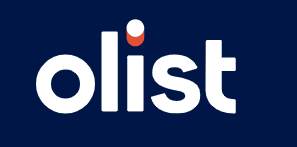

In [1]:
# utilities
import os
os.environ["OMP_NUM_THREADS"] = '1'  # needed to avoid memory leak warning with K-Means in Windows environment

# math & stats
import math

# data analysis
import numpy as np
import pandas as pd

# data visualisation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd
import plotly.express as px
# from yellowbrick.cluster import KElbowVisualizer
# from yellowbrick.features import PCA

# metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score                             
from kneed import KneeLocator

# data preprocessing
from sklearn.preprocessing import scale, StandardScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# from pyclustertend import hopkins  # formula in module contains calculation error - see:
# https://journal.r-project.org/articles/RJ-2022-055/ 
# and https://stats.stackexchange.com/questions/609414/hopkins-statistic-to-exponentiate-or-not-to-exponentiate
from pyclustertend import vat

# configure transformers to output pandas DataFrames
# https://scikit-learn.org/1.5/auto_examples/miscellaneous/
# plot_set_output.html#sphx-glr-auto-examples-miscellaneous-plot-set-output-py
from sklearn import set_config
set_config(transform_output="pandas")

# avoid error message when running GridSearch with OneHotEncoder in Pipe
# Pandas output does not support sparse data. Set sparse_output=False to output pandas dataframes or disable Pandas output via
# ` ohe.set_output(transform="default")
# set_config(transform_output="default")

# PCA
from sklearn.decomposition import PCA

# clustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AffinityPropagation
# from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestNeighbors
import hdbscan

# statistics
import scipy.stats as st
import scikit_posthocs as sp

# import user-defined functions
from functions import *

# set dataframe display options
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

# silence warnings after checking
import warnings
pd.set_option('future.no_silent_downcasting', False)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.set_option('mode.chained_assignment', None)

# extract colors from logo for ppt slideshow
ciel = findColor('olist_blue.png')
cyan = findColor('olist_dark_blue.png')
cherry = findColor('olist_red.png')
print("ciel hex :", ciel)
print("cyan hex :", cyan)
print("cherry hex :", cherry)

ciel hex : #0a4ee4
cyan hex : #001647
cherry hex : #e64e36


In [2]:
# check for PEP-8 compliance
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

In [1]:
# add notebook summary
import jyquickhelper as jqh
from jyquickhelper import add_notebook_menu
add_notebook_menu(menu_id='OCDS_P5', raw=False, format='html',
                  header="Olist Client Segmentation - Clustering", first_level=1, last_level=5,
                  keep_item=None)

In [3]:
# check Python interpreter is running in 64-bit to maximize memory available for calculations
import struct
print(struct.calcsize("P") * 8)

64


# 1 - Import & pre-process data

## 1.1 - Import & typecasting

In [4]:
# Import data
data = pd.read_csv('grouped_data.csv', encoding='utf-8')

In [5]:
data.sample(5)

customer_id state  capital  altitude      c_lat  \
15719  2a146eb24a089c268ea7e15efb9ea6cd    RS    False  588.8139 -28.291481   
45779  7b26bcf0f1e9f21e7102c0fa17087599    RJ    False  117.7836 -22.869185   
86978  e8e70bec13e1af66ae46c8833096aa0c    MG    False  768.8074 -20.053677   
9138   1875ec73420a9c9239ecdeca65259cf2    MG    False  978.7007 -21.109888   
93639  fb5984b299eb1ae66a2f6725317a495c    RJ    False  117.7836 -22.953464   

           c_lon  pop_density  motor_vehicles  GDP_per_capita  post_offices  \
15719 -52.790329        23.56          4733.0       31038.690           3.0   
45779 -43.100049        11.20          4486.0       22918.735           1.0   
86978 -44.261084        51.48          5873.0       13384.100           3.5   
9138  -44.023142       310.42        113082.0       27896.475           2.0   
93639 -43.073200        11.20          4486.0       22918.735           1.0   

       HDI_index  tax_gdp_%  nb_of_orders  total_spent  total_freight  \
15719     0.6475       5.75           1.0        79.90          21.05   
45779     0.6435       5.40           1.0       179.00          16.00   
86978     0.6525       5.91           3.0       149.91          40.92   
9138      0.7580       8.17           1.0        69.90          16.15   
93639     0.6435       5.40           1.0        84.99          14.34   

       total_products  product_weight_avg  review_score_avg pmt_type_mode  \
15719               1              1836.0               5.0   credit_card   
45779               1               263.0               5.0   credit_card   
86978               3              4800.0               2.0   credit_card   
9138                1               950.0               5.0   credit_card   
93639               1               900.0               5.0        boleto   

       pmt_installments_avg  shipping_distance_avg  review_delay_days_avg  \
15719                   1.0             800.103290                    1.0   
45779                   3.0             554.255992                    1.0   
86978                  10.0              19.693203                    1.0   
9138                    5.0             502.643200                    1.0   
93639                   1.0             360.961458                    1.0   

        product_group_mode last_order_date  delivery_timeframe_avg  \
15719      household_items      2018-01-09                    17.5   
45779  discretionary_items      2017-11-11                    22.0   
86978      household_items      2017-12-04                    12.5   
9138       household_items      2018-05-09                    24.5   
93639  discretionary_items      2017-08-29                    14.5   

       order_arrived_late  weekend_shopping  evening_shopping  \
15719                True             False             False   
45779                True              True             False   
86978                True             False              True   
9138                 True             False              True   
93639                True             False             False   

       cust_reviewed_order  desc_and_photos  product_volume_m3  \
15719                 True             True             0.8784   
45779                 True             True             0.2652   
86978                 True             True             4.0000   
9138                  True             True             2.3625   
93639                False             True             0.6732   

       shipping_delay_days_avg  last_order_age_in_days  average_basket  \
15719                     -6.0                   232.0           79.90   
45779                      0.0                   291.0          179.00   
86978                     -4.0                   268.0           49.97   
9138                      -5.0                   112.0           69.90   
93639                     -6.0                   365.0           84.99   

       purchase_frequency  
15719                 0.5  
457

In [6]:
# PCA results show the state and product category features contain little useful information, we therefore remove these columns
data_trim = data.drop(labels=[# 'customer_id',
                              'state',
                              'capital',
                              'c_lat',
                              'c_lon',
                              # 'altitude',
                              # 'pop_density',
                              # 'motor_vehicles',
                              # 'GDP_per_capita', 
                              # 'post_offices', 
                              'HDI_index',  # too correlated with GDP per capita
                              # 'tax_gdp_%',
                              # 'nb_of_orders', 
                              # 'total_spent', # monetary
                              #  'total_freight',
                              # 'total_products', 
                              # 'product_weight_avg',
                              # 'review_score_avg',
                              'pmt_type_mode',
                              'pmt_installments_avg',
                              # 'shipping_distance_avg',
                              'review_delay_days_avg', 
                              'product_group_mode', 
                              # 'last_order_date',
                              # 'delivery_timeframe_avg',
                              'order_arrived_late',
                              'weekend_shopping',
                              'evening_shopping',
                              'cust_reviewed_order',
                              'desc_and_photos',
                              'product_volume_m3', # too correlated with weight
                              'shipping_delay_days_avg',
                              # 'last_order_age_in_days', # recency
                              # 'average_basket', # monetary
                              # 'purchase_frequency' # frequency
], axis=1)

In [7]:
# typecasting
# data_trim['capital'] = data_trim['capital'].astype(int)
# data_trim['order_arrived_late'] = data_trim['order_arrived_late'].astype(int)
# data_trim['weekend_shopping'] = data_trim['weekend_shopping'].astype(int)
# data_trim['evening_shopping'] = data_trim['evening_shopping'].astype(int)
# data_trim['cust_reviewed_order'] = data_trim['cust_reviewed_order'].astype(int)
# data_trim['product_has_description'] = data_trim['product_has_description'].astype(int)
# data_trim['product_has_photos'] = data_trim['product_has_photos'].astype(int)
# data_trim['desc_and_photos'] = data_trim['desc_and_photos'].astype(int)
# data_trim['customer_id'] = data_trim['customer_id'].astype('string')
data_trim['last_order_date'] = pd.to_datetime(data_trim['last_order_date'])
# data_trim['pmt_type_mode'] = data_trim['pmt_type_mode'].astype('category')
# data_trim['product_family_mode'] = data_trim['product_family_mode'].astype('category')
# data_trim['product_group_mode'] = data_trim['product_group_mode'].astype('category')

In [8]:
# Select all numeric columns
numeric_columns = data_trim.select_dtypes(include=[np.number]).columns
data_trim[numeric_columns] = data_trim[numeric_columns].astype(np.longdouble)

# Convert numeric columns to integer type
# data_trim[numeric_columns] = data_trim[numeric_columns].astype(int, errors='ignore')

In [9]:
data_trim.head()

customer_id   altitude  pop_density  motor_vehicles  \
0  00012a2ce6f8dcda20d059ce98491703  742.96640    30.510000     3282.000000   
1  000161a058600d5901f007fab4c27140  834.18050    11.700000     2842.000000   
2  0001fd6190edaaf884bcaf3d49edf079   71.61210    15.400000     8254.000000   
3  0002414f95344307404f0ace7a26f1d5  740.82677    91.218631     9820.626846   
4  000379cdec625522490c315e70c7a9fb  783.61510    81.590000    11148.000000   

   GDP_per_capita  post_offices  tax_gdp_%  nb_of_orders  total_spent  \
0     6556.155000      1.000000   4.040000           1.0        89.80   
1    22740.555000      1.000000   4.820000           1.0        54.90   
2    12271.900000      1.500000   7.230000           1.0       179.99   
3    19464.896791      1.771475   5.320694           1.0       149.90   
4    27499.805000      1.000000   1.850000           1.0        93.00   

   total_freight  total_products  product_weight_avg  review_score_avg  \
0          24.94             1.0              4267.0               1.0   
1          12.51             1.0               150.0               4.0   
2          15.43             1.0               750.0               5.0   
3          29.45             1.0              1600.0               5.0   
4          14.01             1.0               800.0               4.0   

   shipping_distance_avg last_order_date  delivery_timeframe_avg  \
0             120.134678      2017-11-14                    17.0   
1             133.832239      2017-07-16                    14.0   
2             552.074983      2017-02-28                    14.0   
3             834.406263      2017-08-16                    28.5   
4             310.969235      2018-04-02                    13.5   

   last_order_age_in_days  average_basket  purchase_frequency  
0                   288.0           89.80                 0.5  
1                   409.0           54.90                 0.5  
2                   547.0          179.99                 0.5  
3                   378.0          149.90                 0.5  
4                   149.0           93.00                 0.5

In [10]:
data_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95340 entries, 0 to 95339
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             95340 non-null  object        
 1   altitude                95340 non-null  float64       
 2   pop_density             95340 non-null  float64       
 3   motor_vehicles          95340 non-null  float64       
 4   GDP_per_capita          95340 non-null  float64       
 5   post_offices            95340 non-null  float64       
 6   tax_gdp_%               95340 non-null  float64       
 7   nb_of_orders            95340 non-null  float64       
 8   total_spent             95340 non-null  float64       
 9   total_freight           95340 non-null  float64       
 10  total_products          95340 non-null  float64       
 11  product_weight_avg      95340 non-null  float64       
 12  review_score_avg        95340 non-null  float6

In [11]:
data_trim.to_csv('data_trim.csv', encoding='utf-8', index=False)

## 1.2 - Pre-processing

### 1.2.1 - Transform numerical and categorical values

In [12]:
# split data
X = data_trim.copy()
X.drop(labels=['customer_id', 'last_order_date'], axis=1, inplace=True)

In [13]:
X.isna().sum().sum()

0

In [14]:
X.head()

altitude  pop_density  motor_vehicles  GDP_per_capita  post_offices  \
0  742.96640    30.510000     3282.000000     6556.155000      1.000000   
1  834.18050    11.700000     2842.000000    22740.555000      1.000000   
2   71.61210    15.400000     8254.000000    12271.900000      1.500000   
3  740.82677    91.218631     9820.626846    19464.896791      1.771475   
4  783.61510    81.590000    11148.000000    27499.805000      1.000000   

   tax_gdp_%  nb_of_orders  total_spent  total_freight  total_products  \
0   4.040000           1.0        89.80          24.94             1.0   
1   4.820000           1.0        54.90          12.51             1.0   
2   7.230000           1.0       179.99          15.43             1.0   
3   5.320694           1.0       149.90          29.45             1.0   
4   1.850000           1.0        93.00          14.01             1.0   

   product_weight_avg  review_score_avg  shipping_distance_avg  \
0              4267.0               1.0             120.134678   
1               150.0               4.0             133.832239   
2               750.0               5.0             552.074983   
3              1600.0               5.0             834.406263   
4               800.0               4.0             310.969235   

   delivery_timeframe_avg  last_order_age_in_days  average_basket  \
0                    17.0                   288.0           89.80   
1                    14.0                   409.0           54.90   
2                    14.0                   547.0          179.99   
3                    28.5                   378.0          149.90   
4                    13.5                   149.0           93.00   

   purchase_frequency  
0                 0.5  
1                 0.5  
2                 0.5  
3                 0.5  
4                 0.5

In [15]:
# list columns requiring scaling & skew correction
# num_X = ['altitude', 'pop_density', 'motor_vehicles', 'GDP_per_capita', 'post_offices', 'HDI_index', 'tax_gdp_%', 'nb_of_orders',
#          'total_spent', 'total_freight', 'total_products', 'product_weight_avg', 'review_score_avg', 'pmt_installments_avg',
#          'shipping_distance_avg', 'review_delay_days_avg', 'delivery_timeframe_avg','product_volume_m3',
#          'shipping_delay_days_avg', 'last_order_age_in_days', 'average_basket', 'purchase_frequency']

num_X = X.select_dtypes(include=[np.number]).columns

# list columns requiring one-hot encoding
# cat_X = ['order_status', 'state', 'pmt_type_mode', 'product_family_mode']
# cat_X = ['pmt_type_mode', 'product_family_mode']
# cat_X = ['product_group_mode', 'pmt_type_mode']
# cat_X = ['product_group_mode']
# cat_X = ['']

In [16]:
# define transformers
numeric_transformer = Pipeline(steps=[('PowerTransformer', PowerTransformer(method='yeo-johnson',
                                                                            standardize=True, copy=True))])

categorical_transformer = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

In [17]:
# apply column transformer - careful make sure to set remainder='passthrough' otherwise columns not in num_X or cat_X
# will be droppped by default
# see https://datascience.stackexchange.com/questions/116488/how-can-i-let-non-transformed-values-through-scikit-learns-column-transformer

# preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, num_X),
#                                                ("cat", categorical_transformer, cat_X)], remainder='passthrough')

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, num_X)], remainder='passthrough')

In [18]:
# from https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
# clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())])
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# clf.fit(X_train, y_train)
# print("model score: %.3f" % clf.score(X_test, y_test))

In [19]:
clf = Pipeline(steps=[("preprocessor", preprocessor)])
clf.fit(X)
X_scaled = clf.transform(X)

In [20]:
# convert results to float16 to limit memory usage
X_scaled = X_scaled.astype('float16')

In [21]:
X_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95340 entries, 0 to 95339
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   num__altitude                95340 non-null  float16
 1   num__pop_density             95340 non-null  float16
 2   num__motor_vehicles          95340 non-null  float16
 3   num__GDP_per_capita          95340 non-null  float16
 4   num__post_offices            95340 non-null  float16
 5   num__tax_gdp_%               95340 non-null  float16
 6   num__nb_of_orders            95340 non-null  float16
 7   num__total_spent             95340 non-null  float16
 8   num__total_freight           95340 non-null  float16
 9   num__total_products          95340 non-null  float16
 10  num__product_weight_avg      95340 non-null  float16
 11  num__review_score_avg        95340 non-null  float16
 12  num__shipping_distance_avg   95340 non-null  float16
 13  num__delivery_ti

In [22]:
features = X_scaled.columns
print(len(features))
features

17


Index(['num__altitude', 'num__pop_density', 'num__motor_vehicles',
       'num__GDP_per_capita', 'num__post_offices', 'num__tax_gdp_%',
       'num__nb_of_orders', 'num__total_spent', 'num__total_freight',
       'num__total_products', 'num__product_weight_avg',
       'num__review_score_avg', 'num__shipping_distance_avg',
       'num__delivery_timeframe_avg', 'num__last_order_age_in_days',
       'num__average_basket', 'num__purchase_frequency'],
      dtype='object')

In [23]:
# save copy of dataframe to csv
X_scaled.to_csv('X-scaled.csv', index=False, encoding='utf-8')

In [24]:
X_scaled.shape

(95340, 17)

### 1.2.2 - Data reduction / summarization

In [25]:
batch_size = 9534
max_iter = 100
n_clusters_range = range(100, 1001, 100)

results = []

for n_clusters in n_clusters_range:
    mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, max_iter=max_iter, random_state=42, verbose=True)
    cluster_labels = mbk.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    results.append((n_clusters, silhouette_avg))

# Find the best number of clusters
best_n_clusters = max(results, key=lambda x: x[1])[0]
print(f"Best number of clusters: {best_n_clusters}")

Best number of clusters: 1000


In [26]:
final_mbk = MiniBatchKMeans(n_clusters=best_n_clusters, batch_size=batch_size, max_iter=max_iter, random_state=42)
reduced_data = final_mbk.fit_predict(X_scaled)

In [27]:
centroids_1000 = final_mbk.cluster_centers_
centroids_km_1000 = pd.DataFrame(centroids_1000)
centroids_km_1000.columns = features
centroids_km_1000.head()

num__altitude  num__pop_density  num__motor_vehicles  num__GDP_per_capita  \
0      -1.237158         -0.614042            -0.603354             0.623058   
1       0.180523         -0.006031            -0.322261            -0.560421   
2       0.582022         -0.522720            -0.316007             1.435235   
3       0.559125          1.719513             1.371655             0.931676   
4       0.733573          0.561047             0.701738             0.779937   

   num__post_offices  num__tax_gdp_%  num__nb_of_orders  num__total_spent  \
0          -0.133743        0.424535          -0.388184         -1.456171   
1          -0.318622        0.234703          -0.388184          0.211393   
2          -0.081999        0.930453          -0.388184         -1.027758   
3           0.629100        2.179733           2.576476          0.438902   
4          -0.482163       -1.166673          -0.388184         -0.026171   

   num__total_freight  num__total_products  num__product_weight_avg  \
0           -0.116884            -0.388184                -1.012133   
1            0.142883            -0.388184                 0.895354   
2           -0.368571            -0.388184                -0.933739   
3            1.302448             2.576476                 0.051941   
4           -0.050261            -0.388184                 0.583392   

   num__review_score_avg  num__shipping_distance_avg  \
0              -1.024280                    0.457356   
1              -0.680552                    0.572975   
2               0.630428                    0.051696   
3              -1.356890                    0.200229   
4               0.770610                   -0.145987   

   num__delivery_timeframe_avg  num__last_order_age_in_days  \
0                    -0.086809                    -1.296653   
1                     0.719109                     0.643152   
2                    -0.523095                    -1.071538   
3                     0.487805                    -0.151103   
4                    -1.289852                    -1.697949   

   num__average_basket  num__purchase_frequency  
0            -1.361984                -0.388184  
1             0.335586                -0.388184  
2            -0.925134                -0.388184  
3            -0.372767                 2.577040  
4             0.094486                -0.388184

In [28]:
X_reduced = centroids_km_1000.copy()

In [29]:
data_clust_red = data.copy()
data_clust_red['cluster_id_red'] = (final_mbk.labels_)
print(data_clust_red.shape)
data_clust_red.sample(5)

(95340, 36)


customer_id state  capital  altitude      c_lat  \
83582  dfe9825762431b40b05e387b94712d60    PR     True  910.8939 -25.424627   
24876  42d941d7421f648124342e05e8478022    SP     True  783.6151 -23.572234   
80002  d6028dc827eae81534f01a813de8d9f9    SP    False  688.9871 -22.816223   
16102  2b2689b4085eeeda6fc6022b2d7b086c    RS    False   15.3865 -31.771331   
7572   1470ea637a213181fd75f1f67921bd40    PR     True  910.8939 -25.492922   

           c_lon  pop_density  motor_vehicles  GDP_per_capita  post_offices  \
83582 -49.253823       119.54          6288.0       10218.130           2.5   
24876 -46.624965        81.59         11148.0       27499.805           1.0   
80002 -47.071747        50.31          7173.0       14240.635           2.0   
16102 -52.327912        30.11          2686.0       12564.025           1.0   
7572  -49.235698       119.54          6288.0       10218.130           2.5   

       HDI_index  tax_gdp_%  nb_of_orders  total_spent  total_freight  \
83582     0.6230       7.19           1.0        19.90          15.23   
24876     0.7020       1.85           2.0       113.98          17.44   
80002     0.6465       2.09           1.0        37.50           9.34   
16102     0.6335       3.74           1.0        53.90          16.07   
7572      0.6230       7.19           4.0       153.60          60.44   

       total_products  product_weight_avg  review_score_avg pmt_type_mode  \
83582               1               150.0               5.0   credit_card   
24876               2               375.0               5.0        boleto   
80002               1               750.0               5.0   credit_card   
16102               1              1800.0               5.0        boleto   
7572                4               850.0               1.0   credit_card   

       pmt_installments_avg  shipping_distance_avg  review_delay_days_avg  \
83582                   1.0             672.715389                    1.0   
24876                   1.0              14.177660                    1.0   
80002                   4.0             115.554841                    1.0   
16102                   1.0            1253.804070                    1.0   
7572                    1.0             343.161063                    1.0   

        product_group_mode last_order_date  delivery_timeframe_avg  \
83582      household_items      2018-05-22                    16.5   
24876  discretionary_items      2017-09-21                    14.0   
80002          other_items      2017-12-03                    13.0   
16102      household_items      2018-05-07                    24.0   
7572       household_items      2017-10-26                    15.0   

       order_arrived_late  weekend_shopping  evening_shopping  \
83582                True             False             False   
24876                True             False             False   
80002                True              True             False   
16102                True             False              True   
7572                 True             False             False   

       cust_reviewed_order  desc_and_photos  product_volume_m3  \
83582                False             True            0.19200   
24876                False             True            0.40225   
80002                False             True            2.27250   
16102                False             True            3.25600   
7572                 False             True            1.00000   

       shipping_delay_days_avg  last_order_age_in_days  average_basket  \
83582                     -1.0                    99.0           19.90   
24876                     -7.0                   342.0           56.99   
80002                     -4.0                   269.0           37.50   
16102                     -6.0                   114.0           53.90   
7572                      -4.0                   307.0           38.40   

       purchase_frequency  cluster_id_red  
83582          

In [30]:
clusters_red = data_clust_red.groupby('cluster_id_red')['customer_id'].count().reset_index()
clusters_red.head()

cluster_id_red  customer_id
0               0           74
1               1          122
2               2          147
3               3           56
4               4          188

In [31]:
clusters_red['customer_id'].min()

5

In [32]:
clusters_red['customer_id'].max()

347

**The clusters vary in size from 5 customers to 347 customers per cluster.**

In [33]:
# check numbers of customers tally
clusters_red['customer_id'].sum()

95340

In [34]:
clusters_red = clusters_red.rename(columns={'cluster_id_red' : 'cluster_red', 'customer_id' : 'customers_in_cluster_red'})

In [35]:
data_clust_reduced = pd.merge(X_reduced, clusters_red, how='left', left_index=True, right_on='cluster_red')
data_clust_reduced['cluster_red'] = data_clust_reduced['cluster_red'] + 1
print(data_clust_reduced.shape)
data_clust_reduced.head(10)

(1000, 19)


num__altitude  num__pop_density  num__motor_vehicles  num__GDP_per_capita  \
0      -1.237158         -0.614042            -0.603354             0.623058   
1       0.180523         -0.006031            -0.322261            -0.560421   
2       0.582022         -0.522720            -0.316007             1.435235   
3       0.559125          1.719513             1.371655             0.931676   
4       0.733573          0.561047             0.701738             0.779937   
5       0.750213         -0.670240            -0.907261            -0.992018   
6       0.214171          0.557724             0.641722             0.389193   
7       0.770170          0.548855             0.722229             0.789678   
8      -1.515807          0.748188            -1.388703            -1.480016   
9      -0.987045         -0.602706            -0.083102            -0.073980   

   num__post_offices  num__tax_gdp_%  num__nb_of_orders  num__total_spent  \
0          -0.133743        0.424535          -0.388184         -1.456171   
1          -0.318622        0.234703          -0.388184          0.211393   
2          -0.081999        0.930453          -0.388184         -1.027758   
3           0.629100        2.179733           2.576476          0.438902   
4          -0.482163       -1.166673          -0.388184         -0.026171   
5          -0.404619       -0.230502           2.576823          1.167258   
6           0.304120       -0.032205          -0.388184         -1.027340   
7          -0.579024       -1.289755          -0.388184         -0.599674   
8          -2.101669       -0.200292          -0.388184          0.347047   
9           1.065887       -0.115829          -0.388184          1.220830   

   num__total_freight  num__total_products  num__product_weight_avg  \
0           -0.116884            -0.388184                -1.012133   
1            0.142883            -0.388184                 0.895354   
2           -0.368571            -0.388184                -0.933739   
3            1.302448             2.576476                 0.051941   
4           -0.050261            -0.388184                 0.583392   
5            1.766861             2.576823                 0.734167   
6           -0.550738            -0.388184                 0.039050   
7           -1.163177            -0.388184                -0.181139   
8            0.449807            -0.388184                -0.297399   
9            2.500336            -0.388184                 1.671638   

   num__review_score_avg  num__shipping_distance_avg  \
0              -1.024280                    0.457356   
1              -0.680552                    0.572975   
2               0.630428                    0.051696   
3              -1.356890                    0.200229   
4               0.770610                   -0.145987   
5               0.665697                   -0.005984   
6               0.770348                   -0.090873   
7              -0.744400                   -1.531432   
8               0.360255                    1.419454   
9               0.668768                    1.793004   

   num__delivery_timeframe_avg  num__last_order_age_in_days  \
0                    -0.086809                    -1.296653   
1                     0.719109                     0.643152   
2                    -0.523095                    -1.071538   
3                     0.487805                    -0.151103   
4                    -1.289852                    -1.697949   
5                    -0.669990                    -1.297996   
6                     0.035143                     1.433922   
7                    -1.021129                     0.063299   
8                     1.319185                    -0.758304   
9                     1.442270                    -0.430011   

   num__average_basket  num__purchase_frequency  cluster_red  \
0            -1.361984                -0.388184            1   
1             0.335586                -0.388184      

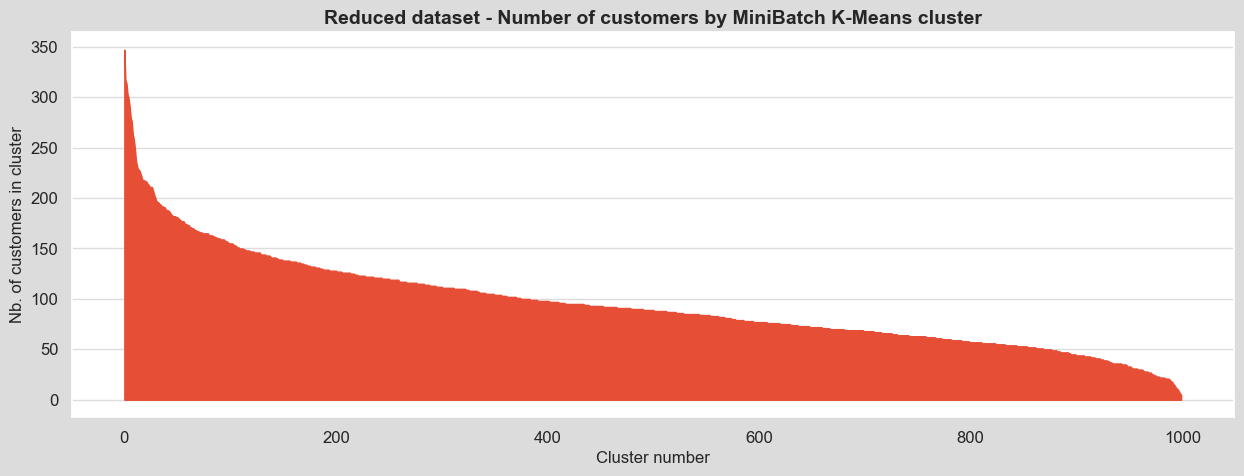

In [36]:
sns.set(rc={'figure.figsize':(15, 5), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
x = data_clust_reduced.index
y = data_clust_reduced.sort_values(by='customers_in_cluster_red', ascending=False)['customers_in_cluster_red']

# plt.bar([a for a in x], y)
plt.fill_between(x, y, color=cherry)
plt.xlabel('Cluster number', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Nb. of customers in cluster', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', color='gainsboro')
plt.title('Reduced dataset - Number of customers by MiniBatch K-Means cluster', fontsize=14, fontweight='bold')
plt.show()

## 1.3 - Hopkins test

Standard Scaling is generally more reliable in preserving the underlying data structure. Since the Hopkins Test evaluates spatial distribution, Standard Scaling is likely to provide a clearer representation of whether data truly has clusters.
Source : https://www.kaggle.com/discussions/general/555915  
See https://www.youtube.com/watch?v=E2VAV9eUh1o for graphical interpretation of results.

In [37]:
my_hopkins(X_reduced)

0.9999997440486758

**The Hopkins statistic indicates the pre-clustered data very likely contains clusters.**

## 1.4 - VAT

VAT (visual assessment of tendency) is a algorithm which create a visualisation of a specific dataset, this visualisation can be useful to obtain an insight on the number of cluster and cluster hierarchy. The algorithm create a minimum spanning tree of observations, The pairwise distance between those observations are displayed. The more the color is black, the more the distance between two observations is small. A way to interpert the image is to count the number of black square in the diagonal which should represent the number of cluster.
Source : https://pyclustertend.readthedocs.io/en/latest/

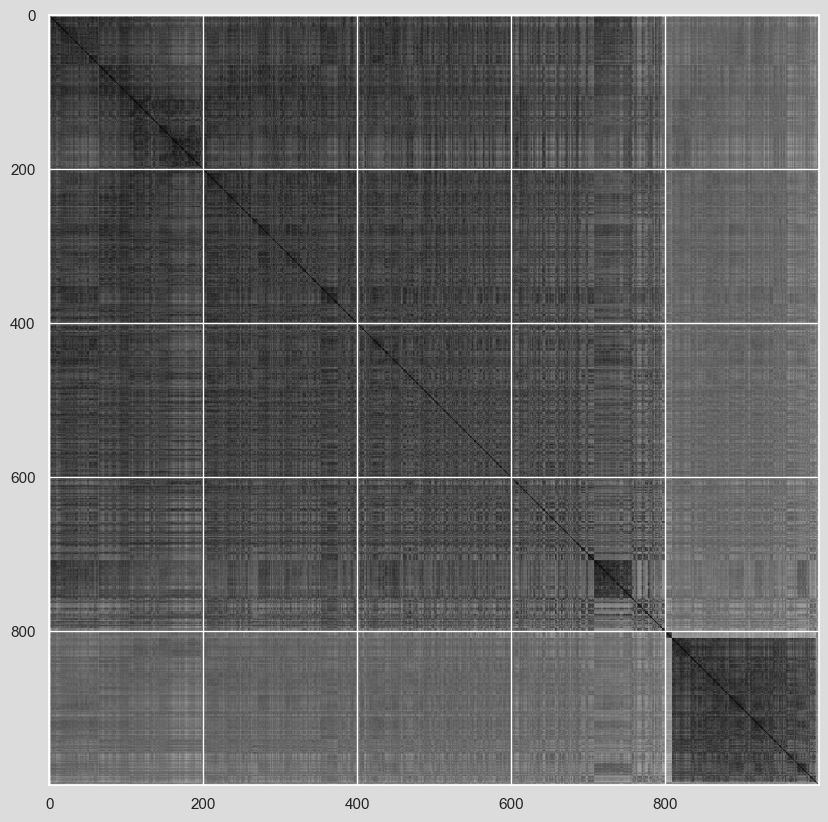

In [38]:
# X = scale(datasets.load_iris().data)
vat(X_reduced)

**The VAT test indicates there are likely 2 clusters in the data, with 2 possible small sub-clusters inside the larger cluster.**

# 2 - PCA

In [39]:
# components = data.shape[1]
components_red = 10
pca_red = PCA(n_components=components_red)

# use pca = PCA(n_components=0.80) to capture 80% of total variance
# the algorithm automatically selects the best number of principal components that keep 80%
# of the variance in the original data.
# to know how many components the algorithm has selected, run pca.n_components_
pca_red.fit(X_reduced)

PCA(n_components=10)

In [40]:
# create scree plot
scree_red = (pca_red.explained_variance_ratio_*100).round(2)
scree_cum_red = scree_red.cumsum().round()
a_list_red = range(1, components_red+1)
# list(a_list)

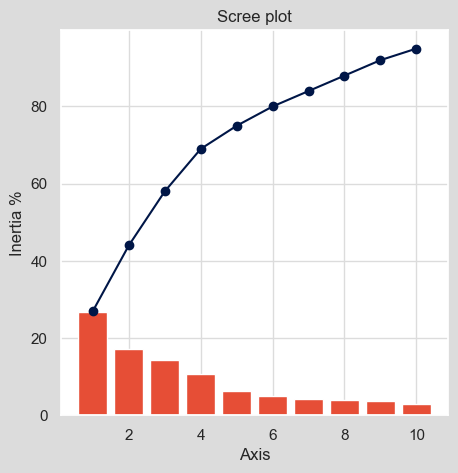

In [41]:
# plot data
plt.figure(figsize=(5,5))
plt.bar(a_list_red, scree_red, color=cherry)
plt.plot(a_list_red, scree_cum_red, color=cyan, marker='o')
plt.xlabel("Axis")
plt.ylabel("Inertia %")
plt.title("Scree plot")
plt.grid(axis='both', color='gainsboro')
plt.savefig("eboulis_red.png", bbox_inches='tight')
plt.show(block=False)

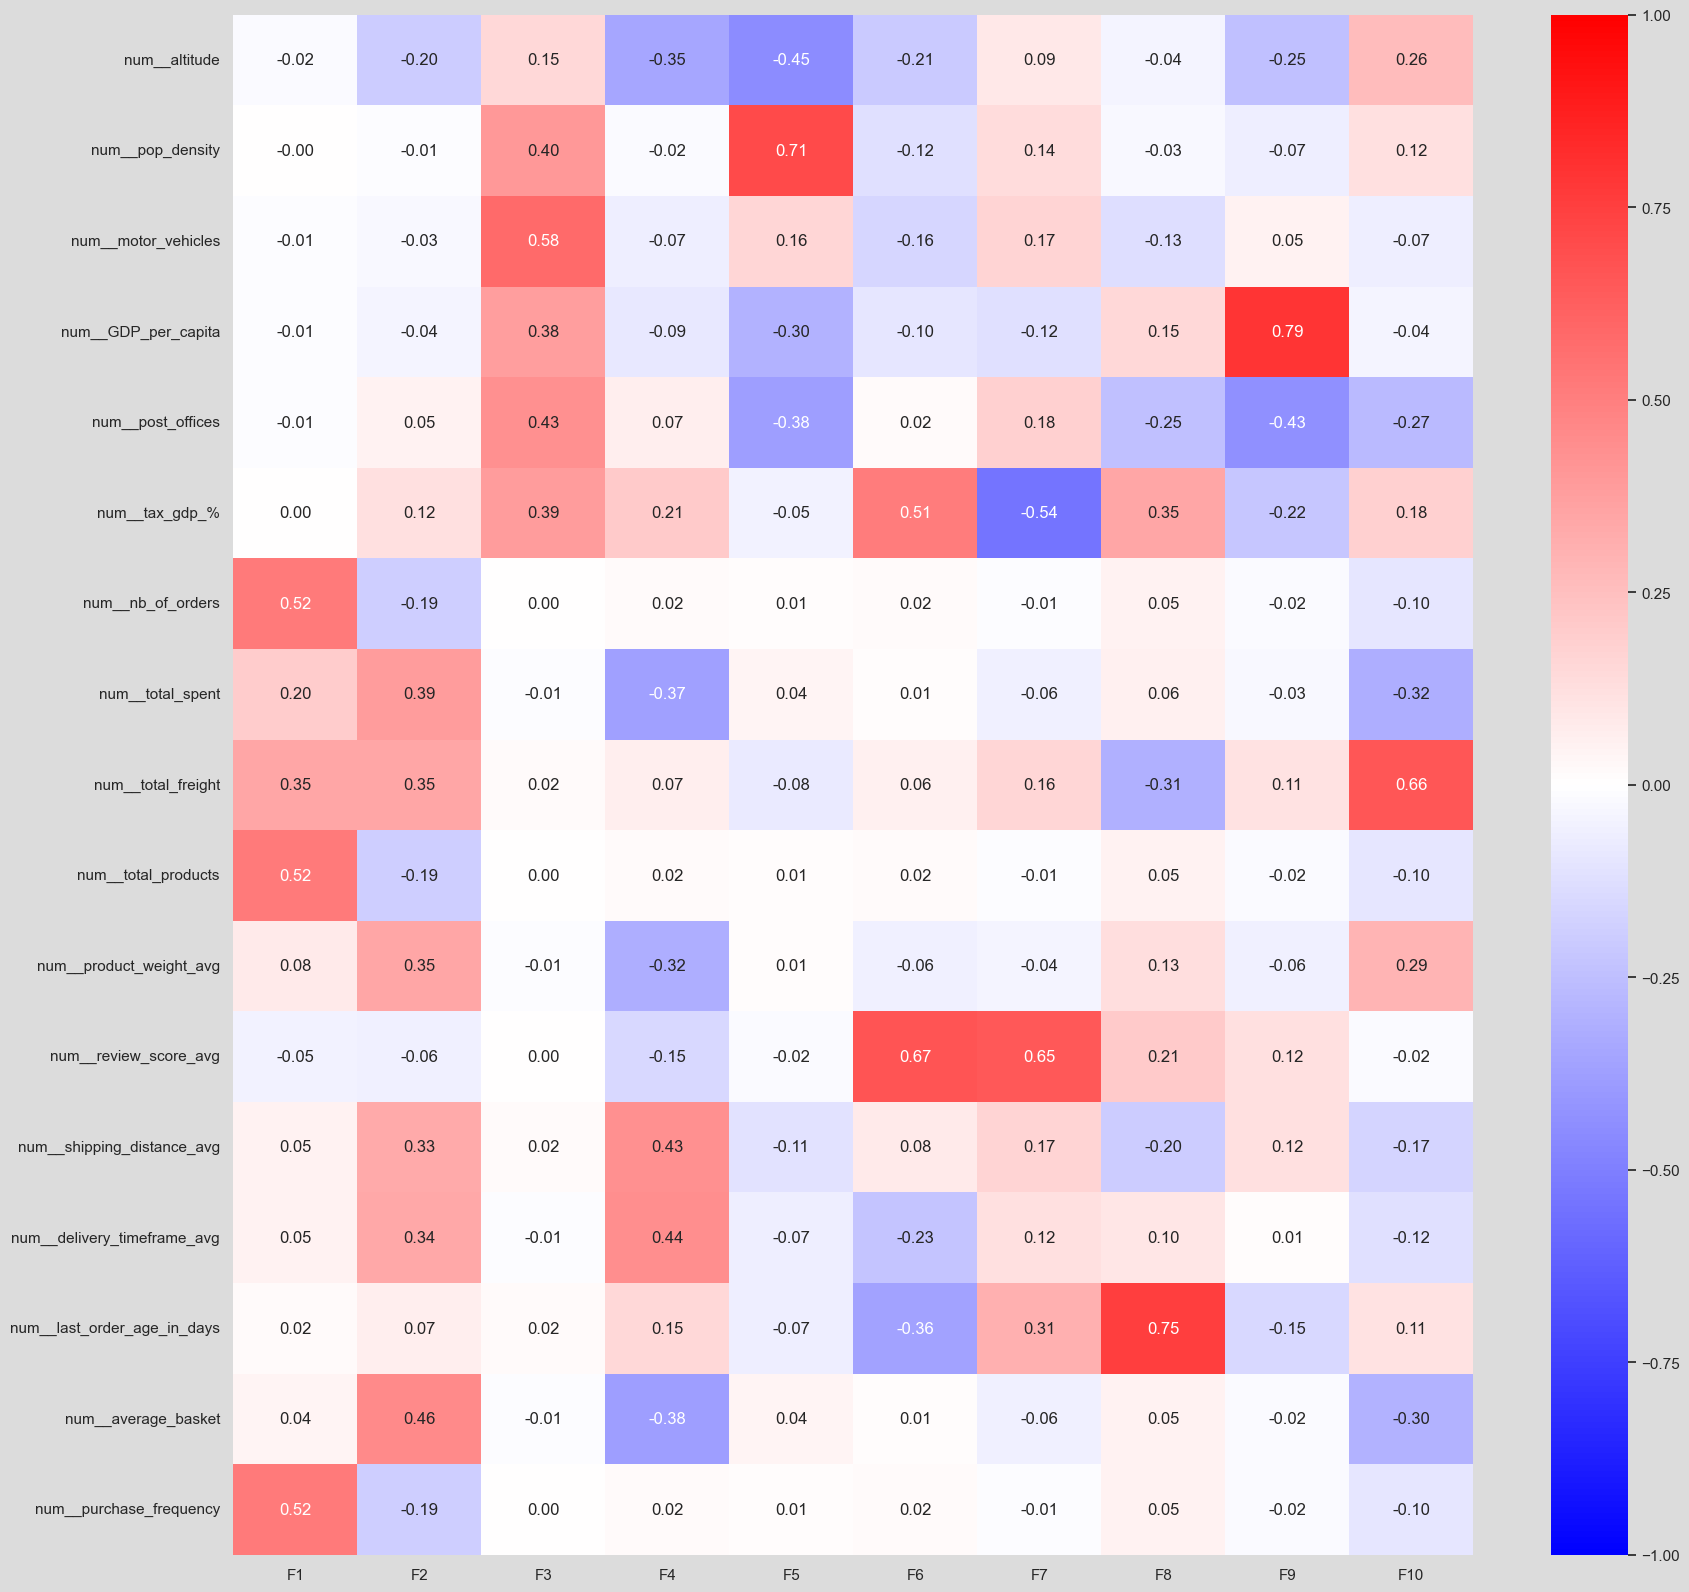

In [42]:
# create components dataframe
acp_components_red = pd.DataFrame(pca_red.components_)
acp_components_red.columns = features
acp_components_red.index = [f"F{i}" for i in a_list_red]

# plot heatmap
fig, ax = plt.subplots(figsize=(20, 20))
acp_heatmap_red = sns.heatmap(acp_components_red.T.round(2), vmin=-1, vmax=1, annot=True, cmap="bwr", fmt="0.2f")
plt.savefig("acp_heatmap_2.png")

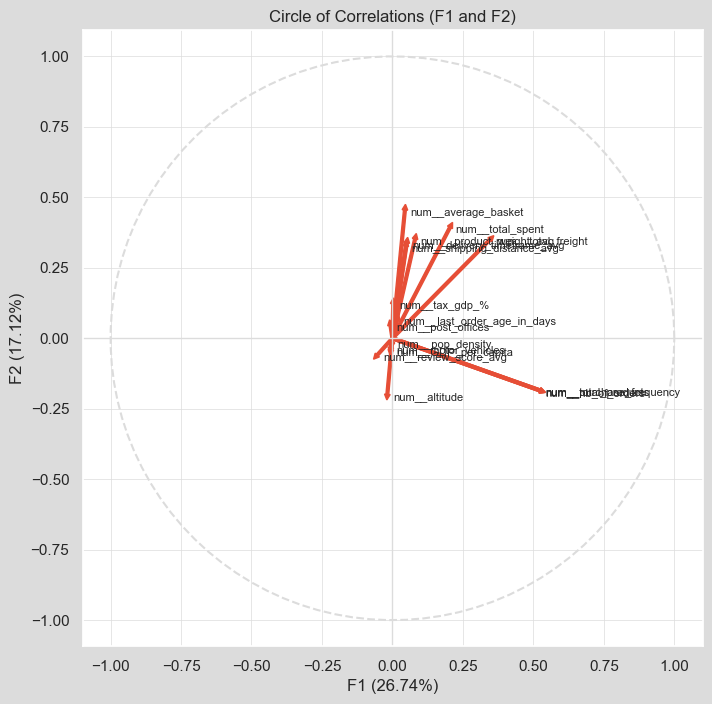

In [43]:
# draw correlation circle for axes 1 and 2
x_y = (0, 1)
correlation_graph(pca_red, x_y, features, col=cherry)

# 3 - Clustering on pre-clustered & reduced dataset

## 3.1 - Hierarchical ascending classification

In [44]:
print(X_reduced.shape)
X_reduced.head(1)

(1000, 17)


num__altitude  num__pop_density  num__motor_vehicles  num__GDP_per_capita  \
0      -1.237158         -0.614042            -0.603354             0.623058   

   num__post_offices  num__tax_gdp_%  num__nb_of_orders  num__total_spent  \
0          -0.133743        0.424535          -0.388184         -1.456171   

   num__total_freight  num__total_products  num__product_weight_avg  \
0           -0.116884            -0.388184                -1.012133   

   num__review_score_avg  num__shipping_distance_avg  \
0               -1.02428                    0.457356   

   num__delivery_timeframe_avg  num__last_order_age_in_days  \
0                    -0.086809                    -1.296653   

   num__average_basket  num__purchase_frequency  
0            -1.361984                -0.388184

In [45]:
# linkage
Z = shc.linkage(X_reduced.astype('float16'), method="ward", optimal_ordering=True,
                metric='euclidean')  # metric='euclidean' is implied by use of Ward method

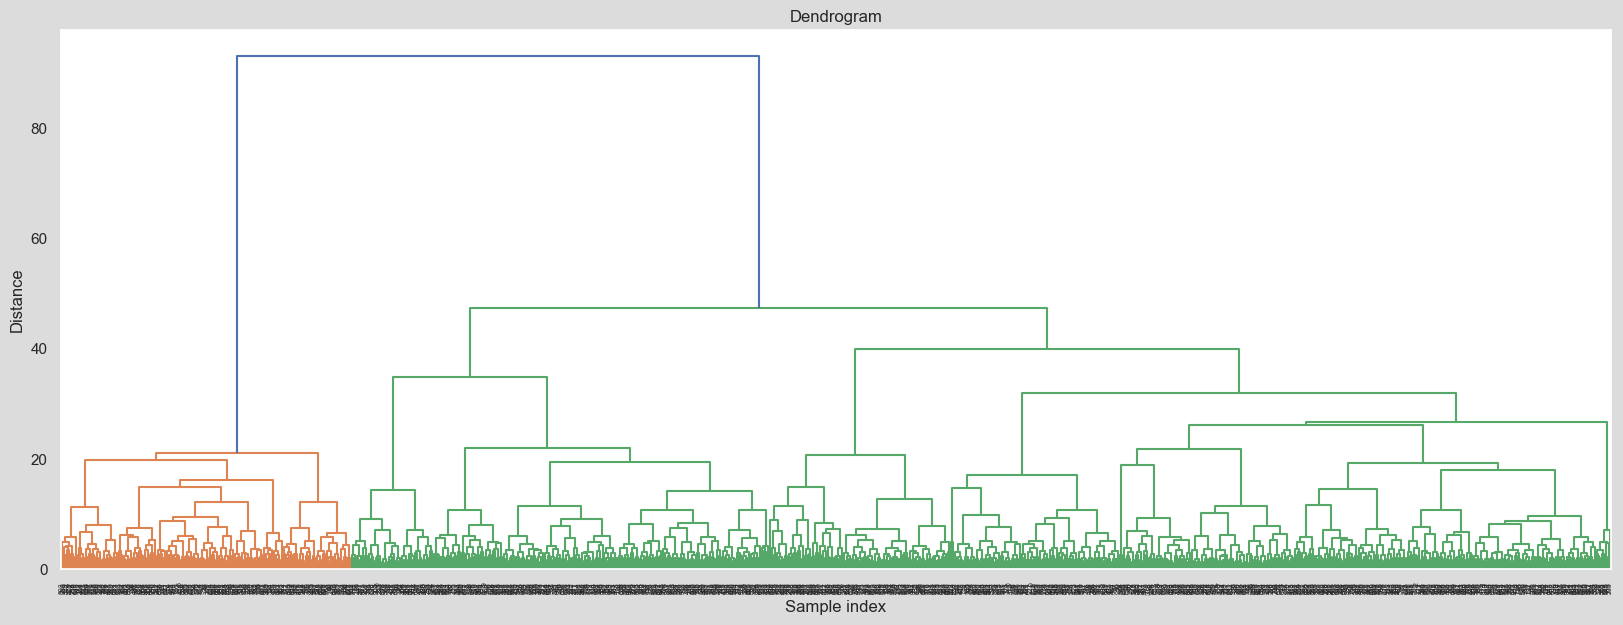

In [46]:
# plot Dendrogram
plt.figure(figsize=(20, 7))
shc.dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

**To find graphically the best numbers of clusters in a dendrogram, it is required to find the largest horizontal space that doesn't have any vertical lines. Here, this is the case where distance > 50. Let us verify this result mathematically with the Silhouette score.**

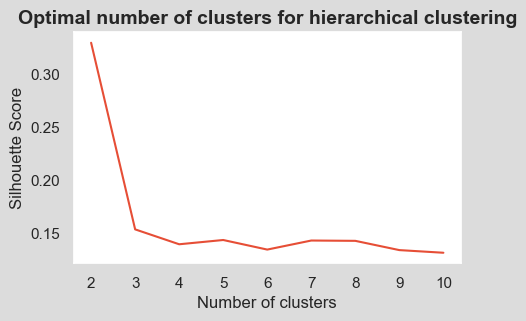

Optimal number of clusters: 2


In [47]:
# determine optimal number of clusters
silhouette_scores_z = []
cluster_range = range(2, 11)  # Test cluster sizes from 2 to 10

for n_clusters in cluster_range:
    labels = shc.fcluster(Z, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(X_reduced, labels)
    silhouette_scores_z.append(silhouette_avg)

# plot Silhouette score
plt.figure(figsize=(5, 3))
plt.plot(cluster_range, silhouette_scores_z, color=cherry)
plt.title('Optimal number of clusters for hierarchical clustering', fontsize=14, fontweight='bold')
plt.xlabel('Number of clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(cluster_range)
plt.grid(axis='y', color='gainsboro')
plt.grid()
plt.show()

# Optimal number of clusters based on maximum silhouette score
optimal_clusters = cluster_range[np.argmax(silhouette_scores_z)]
print(f'Optimal number of clusters: {optimal_clusters}')

In [48]:
# print list of pre-clusters in each cluster
k = optimal_clusters
dendro_clusters = shc.fcluster(Z, k, criterion='maxclust')

data_clust_reduced['dendro_clusters'] = dendro_clusters

In [49]:
clust_list = data_clust_reduced.groupby('dendro_clusters')['cluster_red'].unique().tolist()
print('Cluster 1: \n', *clust_list[0], '\n')
print('Cluster 2: \n', *clust_list[1], '\n')

Cluster 1: 
 4 6 16 17 19 20 35 44 45 52 53 55 61 66 71 97 98 100 105 107 110 126 130 132 139 151 152 162 167 173 180 185 190 191 195 204 214 223 225 226 244 245 248 256 269 270 274 275 276 288 295 308 313 316 326 330 332 336 338 339 340 344 349 355 362 374 386 389 393 400 401 403 407 409 420 441 446 447 453 456 458 466 468 469 478 480 484 486 487 488 498 500 506 507 509 518 520 525 545 558 560 564 570 576 577 579 581 593 594 604 605 611 617 619 623 632 634 637 639 651 657 658 668 669 672 676 683 684 688 699 701 706 712 717 721 722 730 738 751 752 755 762 763 771 772 783 785 789 790 793 801 804 807 817 822 836 841 849 852 853 854 879 880 883 884 886 895 907 917 921 923 925 931 938 939 940 944 952 957 964 971 978 980 981 982 991 993 

Cluster 2: 
 1 2 3 5 7 8 9 10 11 12 13 14 15 18 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 46 47 48 49 50 51 54 56 57 58 59 60 62 63 64 65 67 68 69 70 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 99 101 

In [50]:
# print number of pre-clusters and customers in each dendro cluster
cluster_dendro_1_red = data_clust_reduced.loc[data_clust_reduced['dendro_clusters'] == 1]['cluster_red'].count()
cluster_dendro_1_red_pop = data_clust_reduced.loc[data_clust_reduced['dendro_clusters'] == 1]['customers_in_cluster_red'].sum()
print('Nb of customer pre-clusters in 1st cluster :', cluster_dendro_1_red, '. Population : ', cluster_dendro_1_red_pop)
cluster_dendro_2_red = data_clust_reduced.loc[data_clust_reduced['dendro_clusters'] == 2]['cluster_red'].count()
cluster_dendro_2_red_pop = data_clust_reduced.loc[data_clust_reduced['dendro_clusters'] == 2]['customers_in_cluster_red'].sum()
print('Nb of customer pre-clusters in 2nd cluster :', cluster_dendro_2_red, '. Population : ', cluster_dendro_2_red_pop)
print('Total customers :', (cluster_dendro_1_red_pop + cluster_dendro_2_red_pop),
      '. Total pre-clusters :', (cluster_dendro_1_red + cluster_dendro_2_red))

Nb of customer pre-clusters in 1st cluster : 187 . Population :  12437
Nb of customer pre-clusters in 2nd cluster : 813 . Population :  82903
Total customers : 95340 . Total pre-clusters : 1000


**Hierarchical clustering returns 2 rather unbalanced clusters. This is not good enough to characterise customers from a marketing and business perspective.**

## 3.2 - K-means

### 3.2.1 - Determine optimal number of clusters

- **Elbow Method:**

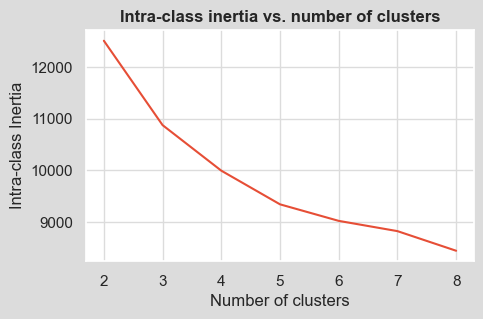

In [51]:
k_list_2 = range(2, 9)

# create data for within-cluster sum of squares for K-means clusters between 2 and 11
wcss_2 = []

for i in k_list_2 :
    kmeans_wcss_2 = KMeans(n_clusters=i, init='k-means++', copy_x=True, algorithm='lloyd', n_init='auto', max_iter=300,
                           verbose=0, random_state=42)
    kmeans_wcss_2.fit(X_reduced)
    wcss_2.append(kmeans_wcss_2.inertia_)

# plot wcss curve
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.set_ylabel('Intra-class Inertia')
ax.set_xlabel('Number of clusters')
ax.set_title('Intra-class inertia vs. number of clusters', fontsize=12, fontweight='bold')
ax = plt.plot(k_list_2, wcss_2, color=cherry)
plt.xticks(np.arange(min(k_list_2), max(k_list_2)+1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig('kmeans_elbow_reduced.png', bbox_inches='tight')
plt.show()

In [52]:
knee_9 = KneeLocator(range(2, 9), wcss_2, S=0.1, curve="convex", direction="decreasing")
knee_k_9 = knee_9.elbow   
print("elbow at k =", f'{knee_k_9:.0f} clusters')

elbow at k = 4 clusters


- **Sihouette score:**

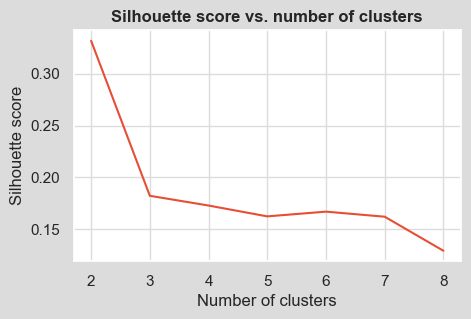

In [53]:
silhouette_2 = []

for j in k_list_2 :
    kmeans_silh_2 = KMeans(n_clusters=j, init='k-means++', copy_x=True, algorithm='lloyd', n_init=30, max_iter=300, verbose=0,
                         random_state=42)
    kmeans_silh_2.fit(X_reduced)
    silh_2 = silhouette_score(X_reduced, kmeans_silh_2.labels_, random_state=42, sample_size=10000)
    silhouette_2.append(silh_2)
    
# plot silhouette score curve
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.set_ylabel('Silhouette score')
ax.set_xlabel('Number of clusters')
ax.set_title('Silhouette score vs. number of clusters', fontsize=12, fontweight='bold')
ax = plt.plot(k_list_2, silhouette_2, color=cherry)
plt.xticks(np.arange(min(k_list_2), max(k_list_2)+1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig('silhouette_reduced.png', bbox_inches='tight')
plt.show()

- **Davies-Bouldin index:**

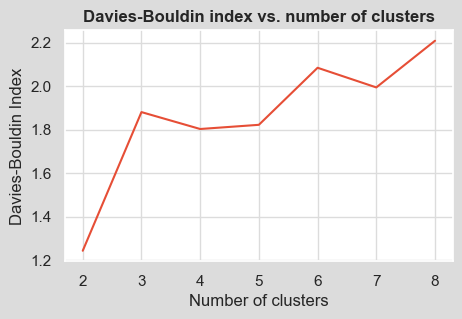

In [54]:
dav_bould_2 = []

for h in k_list_2 :
    kmeans_db_2 = KMeans(n_clusters=h, init='k-means++', copy_x=True, algorithm='lloyd', n_init='auto', max_iter=300, verbose=0,
                         random_state=42)
    kmeans_db_2.fit(X_reduced)
    d_b_2 = davies_bouldin_score(X_reduced, kmeans_db_2.labels_)
    dav_bould_2.append(d_b_2)

# plot Davies-Bouldin score curve
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.set_ylabel('Davies-Bouldin Index')
ax.set_xlabel('Number of clusters')
ax.set_title('Davies-Bouldin index vs. number of clusters', fontsize=12, fontweight='bold')
ax = plt.plot(k_list_2, dav_bould_2, color=cherry)
plt.xticks(np.arange(min(k_list_2), max(k_list_2)+1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig('davies_bouldin_reduced.png', bbox_inches='tight')
plt.show()

**4 clusters also minimises the Davies-Boulding index.**

- **Calinski-Harabasz score:**

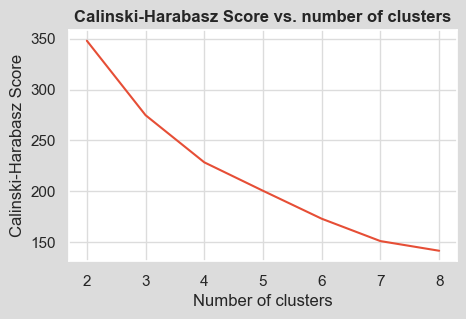

In [55]:
cal_hara_2 = []

for g in k_list_2 :
    kmeans_ch_2 = KMeans(n_clusters=g, init='k-means++', copy_x=True, algorithm='lloyd', n_init='auto', max_iter=300, verbose=0,
                         random_state=42)
    kmeans_ch_2.fit(X_reduced)
    c_h_2 = calinski_harabasz_score(X_reduced, kmeans_ch_2.labels_)
    cal_hara_2.append(c_h_2)

# plot Calinski-Harabasz score curve
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.set_ylabel('Calinski-Harabasz Score')
ax.set_xlabel('Number of clusters')
ax.set_title('Calinski-Harabasz Score vs. number of clusters', fontsize=12, fontweight='bold')
ax = plt.plot(k_list_2, cal_hara_2, color=cherry)
plt.xticks(np.arange(min(k_list_2), max(k_list_2)+1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig('calinski_harabasz_reduced.png', bbox_inches='tight')
plt.show()

**As both the elbow method and the Davis-Bouldin index indicate 4 clusters as the optimal number, we will run the model with this number, despite the Silhouette Score and Calinski-Harabasz Score giving slightly different results.**

### 3.2.2 - K-means with 4 clusters

**- K-means clustering:**

In [56]:
data_clust_reduced.head(1)

num__altitude  num__pop_density  num__motor_vehicles  num__GDP_per_capita  \
0      -1.237158         -0.614042            -0.603354             0.623058   

   num__post_offices  num__tax_gdp_%  num__nb_of_orders  num__total_spent  \
0          -0.133743        0.424535          -0.388184         -1.456171   

   num__total_freight  num__total_products  num__product_weight_avg  \
0           -0.116884            -0.388184                -1.012133   

   num__review_score_avg  num__shipping_distance_avg  \
0               -1.02428                    0.457356   

   num__delivery_timeframe_avg  num__last_order_age_in_days  \
0                    -0.086809                    -1.296653   

   num__average_basket  num__purchase_frequency  cluster_red  \
0            -1.361984                -0.388184            1   

   customers_in_cluster_red  dendro_clusters  
0                        74                2

In [57]:
# create dataframe to hold clustering information
# data_clust_reduced = X_reduced.copy()
print(data_clust_reduced.shape)
data_clust_reduced.head(1)

(1000, 20)


num__altitude  num__pop_density  num__motor_vehicles  num__GDP_per_capita  \
0      -1.237158         -0.614042            -0.603354             0.623058   

   num__post_offices  num__tax_gdp_%  num__nb_of_orders  num__total_spent  \
0          -0.133743        0.424535          -0.388184         -1.456171   

   num__total_freight  num__total_products  num__product_weight_avg  \
0           -0.116884            -0.388184                -1.012133   

   num__review_score_avg  num__shipping_distance_avg  \
0               -1.02428                    0.457356   

   num__delivery_timeframe_avg  num__last_order_age_in_days  \
0                    -0.086809                    -1.296653   

   num__average_basket  num__purchase_frequency  cluster_red  \
0            -1.361984                -0.388184            1   

   customers_in_cluster_red  dendro_clusters  
0                        74                2

In [58]:
# run K-means
kmeans_4_red = KMeans(n_clusters=4, init='k-means++', copy_x=True, algorithm='lloyd', n_init='auto', max_iter=300, verbose=0,
                      random_state=42)
kmeans_4_red.fit(X_reduced)
labels_4_red = kmeans_4_red.labels_

# add cluster number to each customer in clusters dataframe
data_clust_reduced['cluster_kmean_4_red'] = (kmeans_4_red.labels_ + 1)

# print number of customers in each cluster
cluster_4_1_red = data_clust_reduced.loc[data_clust_reduced['cluster_kmean_4_red'] == 1]['cluster_red'].count()
cluster_4_1_red_pop = data_clust_reduced.loc[data_clust_reduced['cluster_kmean_4_red'] == 1]['customers_in_cluster_red'].sum()
print('Nb of customer pre-clusters in 1st cluster :', cluster_4_1_red, '. Population : ', cluster_4_1_red_pop)
cluster_4_2_red = data_clust_reduced.loc[data_clust_reduced['cluster_kmean_4_red'] == 2]['cluster_red'].count()
cluster_4_2_red_pop = data_clust_reduced.loc[data_clust_reduced['cluster_kmean_4_red'] == 2]['customers_in_cluster_red'].sum()
print('Nb of customer pre-clusters in 2nd cluster :', cluster_4_2_red, '. Population : ', cluster_4_2_red_pop)
cluster_4_3_red = data_clust_reduced.loc[data_clust_reduced['cluster_kmean_4_red'] == 3]['cluster_red'].count()
cluster_4_3_red_pop = data_clust_reduced.loc[data_clust_reduced['cluster_kmean_4_red'] == 3]['customers_in_cluster_red'].sum()
print('Nb of customer pre-clusters in 3rd cluster :', cluster_4_3_red, '. Population : ', cluster_4_3_red_pop)
cluster_4_4_red = data_clust_reduced.loc[data_clust_reduced['cluster_kmean_4_red'] == 4]['cluster_red'].count()
cluster_4_4_red_pop = data_clust_reduced.loc[data_clust_reduced['cluster_kmean_4_red'] == 4]['customers_in_cluster_red'].sum()
print('Nb of customer pre-clusters in 4th cluster :', cluster_4_4_red, '. Population : ', cluster_4_4_red_pop)

print('Total customers :', (cluster_4_1_red_pop + cluster_4_2_red_pop + cluster_4_3_red_pop + cluster_4_4_red_pop),
      '. Total pre-clusters :', (cluster_4_1_red + cluster_4_2_red + cluster_4_3_red + cluster_4_4_red))

Nb of customer pre-clusters in 1st cluster : 226 . Population :  19771
Nb of customer pre-clusters in 2nd cluster : 279 . Population :  27386
Nb of customer pre-clusters in 3rd cluster : 189 . Population :  12481
Nb of customer pre-clusters in 4th cluster : 306 . Population :  35702
Total customers : 95340 . Total pre-clusters : 1000


### 3.2.3 - Centroids analysis

In [59]:
centroids_4_red = kmeans_4_red.cluster_centers_
centroids_km_4_red = pd.DataFrame(centroids_4_red)
centroids_km_4_red.columns = features
centroids_km_4_red

num__altitude  num__pop_density  num__motor_vehicles  num__GDP_per_capita  \
0      -0.109302          0.750192             0.909828             0.507657   
1      -0.626405         -0.492935            -0.834343            -0.620639   
2      -0.026130          0.024609             0.020118             0.005918   
3       0.375456         -0.079367             0.116864             0.178725   

   num__post_offices  num__tax_gdp_%  num__nb_of_orders  num__total_spent  \
0           0.713722        0.878978          -0.386723          0.535933   
1          -0.344094       -0.226278          -0.386409          0.341627   
2           0.056540        0.065105           2.574306          0.621911   
3           0.128131       -0.096540          -0.388184         -0.656163   

   num__total_freight  num__total_products  num__product_weight_avg  \
0            0.441575            -0.386723                 0.472606   
1            0.291289            -0.386409                 0.299948   
2            1.176083             2.574306                 0.029788   
3           -0.838387            -0.388184                -0.500363   

   num__review_score_avg  num__shipping_distance_avg  \
0              -0.126399                    0.490897   
1              -0.115670                    0.460017   
2              -0.254751                    0.001381   
3               0.034500                   -0.525890   

   num__delivery_timeframe_avg  num__last_order_age_in_days  \
0                     0.442158                     0.067035   
1                     0.529254                     0.047676   
2                     0.035533                     0.001461   
3                    -0.514515                    -0.192023   

   num__average_basket  num__purchase_frequency  
0             0.662567                -0.386722  
1             0.466053                -0.386409  
2            -0.167342                 2.574794  
3            -0.547459                -0.388184

In [60]:
centroids_km_4_red.index

RangeIndex(start=0, stop=4, step=1)

In [61]:
# plot polar chart centroids
categories = centroids_km_4_red.columns
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=centroids_km_4_red.iloc[0], theta=categories, fill='toself', name='Cluster 1 centroid'))
fig.add_trace(go.Scatterpolar(r=centroids_km_4_red.iloc[1], theta=categories, fill='toself', name='Cluster 2 centroid'))
fig.add_trace(go.Scatterpolar(r=centroids_km_4_red.iloc[2], theta=categories, fill='toself', name='Cluster 3 centroid'))
fig.add_trace(go.Scatterpolar(r=centroids_km_4_red.iloc[3], theta=categories, fill='toself', name='Cluster 4 centroid'))
# fig.add_trace(go.Scatterpolar(r=centroids_km_6.iloc[2], theta=categories, fill='toself', name='Cluster 5 centroid'))
# fig.add_trace(go.Scatterpolar(r=centroids_km_6.iloc[3], theta=categories, fill='toself', name='Cluster 6 centroid'))

fig.update_traces(opacity=0.5, selector=dict(type='scatterpolar'))
# fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, centroids_km_4.max().max()])),showlegend=True)
# fig.write_image("centroids_radar.png")
fig.show()

### 3.2.4 - Graphical representation of clusters

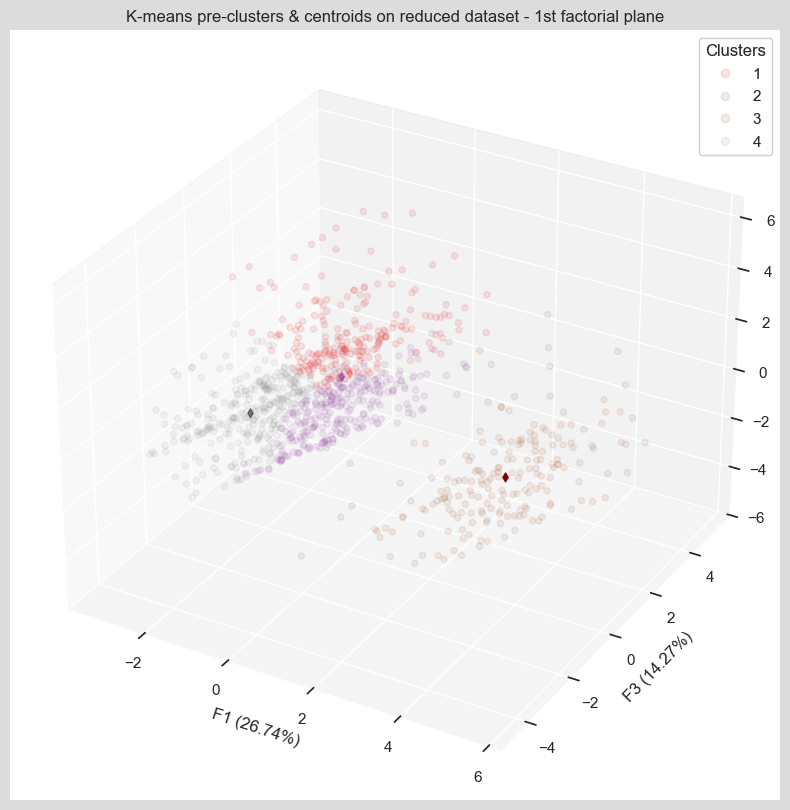

In [62]:
sns.set(rc={'figure.figsize':(10, 10), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})

# plot clusters in 1st factorial plane
pca_kmeans_red = PCA(n_components=4)
pca_kmeans_red.fit(X_reduced)

X_proj_red = pca_kmeans_red.transform(X_reduced)
X_proj_red.rename(columns={'pca0':'PC1','pca1':'PC2','pca2':'PC3','pca3':'PC4'}, inplace=True)

# use initialised scaler 
# centroids_6_scaled = std_scaler.fit_transform(centroids_6)
# centroids_4_scaled_red = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(centroids_km_4_red)
centroids_4_scaled_red = centroids_km_4_red

# use initialised acp 
centroids_4_proj_red = pca_kmeans_red.transform(centroids_4_scaled_red)
centroids_4_proj_red.rename(columns={'pca0':'F1','pca1':'F2','pca2':'F3','pca3':'F4'}, inplace=True)
centroids_4_proj_red.rename(index={'0': 'cluster_1', '1':'cluster_2','2':'cluster_3','3':'cluster_4'}, inplace=True)

# plot results
# fig, ax = plt.subplots(1,1) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(X_proj_red.iloc[:, 0], X_proj_red.iloc[:, 1], X_proj_red.iloc[:, 2],
                     c= data_clust_reduced['cluster_kmean_4_red'], cmap="Set1", alpha =0.1)
ax.scatter(centroids_4_proj_red.iloc[:, 0], centroids_4_proj_red.iloc[:, 1],  marker="d",
                      c=['red', 'blue', 'maroon', 'black'])

ax.set_xlabel('F{} ({}%)'.format(1,round(100*pca_kmeans_red.explained_variance_ratio_[0],2)))
ax.set_ylabel('F{} ({}%)'.format(2,round(100*pca_kmeans_red.explained_variance_ratio_[1],2)))
ax.set_ylabel('F{} ({}%)'.format(3,round(100*pca_kmeans_red.explained_variance_ratio_[2],2)))

# plot thicker abscissa and ordinate lines
# plt.axvline(x=0, c='gainsboro', lw=1, linestyle='solid')
# plt.axhline(y=0, c='gainsboro', lw=1, linestyle='solid')

# produce a legend with the unique colors from the scatter
legend_1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend_1)

ax.set_title("K-means pre-clusters & centroids on reduced dataset - 1st factorial plane")
plt.grid(axis='both', color='gainsboro', lw=0.5)
plt.savefig("Kmeans pre-clusters & centroides on reduced dataset - 1st factorial plane.png", bbox_inches='tight')
plt.show()

## 3.3 - DBSCAN

### 3.3.1 - Determine best eps and min samples

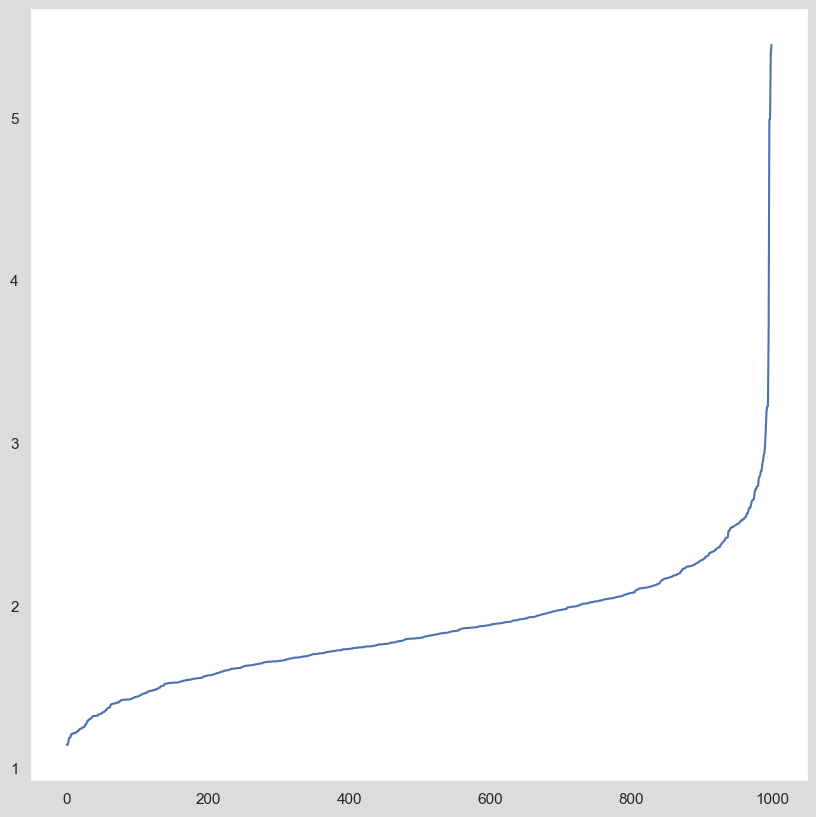

In [63]:
# from sklearn.neighbors import NearestNeighbors
neighbors_red = NearestNeighbors(n_neighbors=X_reduced.shape[1]*2)
neighbors_red_fit = neighbors_red.fit(X_reduced)
distances_red, indices_red = neighbors_red_fit.kneighbors(X_reduced)
distances_red = np.sort(distances_red, axis=0)
distances_red = distances_red[:, 1]
plt.plot(distances_red)

In [64]:
knee_9 = KneeLocator(range(0, len(distances_red)), distances_red, S=0.1, curve="convex", direction="increasing")
knee_k_9 = knee_9.elbow
print("elbow at k =", f'{knee_k_9:.0f}')

elbow at k = 997


In [65]:
eps_red = distances_red[knee_k_9]
eps_red

4.991344138158756

### 3.3.2 - Run model

In [66]:
db_red = DBSCAN(eps=eps_red, min_samples=X_reduced.shape[1]*2).fit(X_reduced)
labels_red = db_red.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_red = len(set(labels_red)) - (1 if -1 in labels_red else 0)
n_noise_red = list(labels_red).count(-1)

print("Estimated number of clusters: %d" % n_clusters_red)
print("Estimated number of noise points: %d" % n_noise_red)

Estimated number of clusters: 2
Estimated number of noise points: 15


In [67]:
# make sure to remove Pandas output otherwise Yellowbrick will not perform the slicing and return
# error InvalidIndexError: (slice(None, None, None), 0) however DF values are accessed
set_config(transform_output="default")

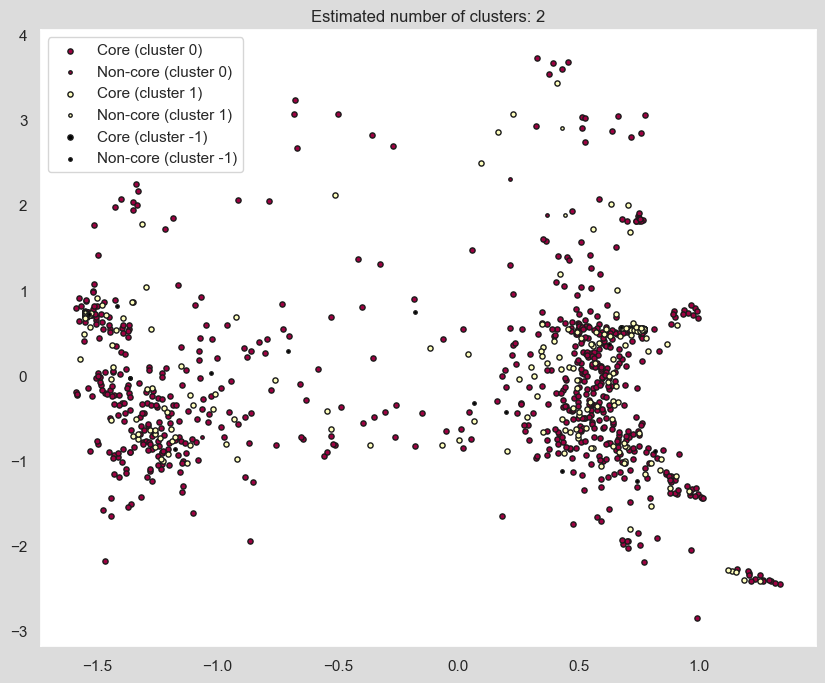

In [68]:
unique_labels_red = set(labels_red)
core_samples_mask_red = np.zeros_like(labels_red, dtype=bool)
core_samples_mask_red[db_red.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_red))]

plt.figure(figsize=(10, 8))

for k, col in zip(unique_labels_red, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise points

    class_member_mask = labels_red == k

    # Core samples
    xy = X_reduced[class_member_mask & core_samples_mask_red]
    plt.scatter(xy.iloc[:, 0], xy.iloc[:, 1], 
                s=14, c=[col], marker='o', edgecolors='k', label=f'Core (cluster {k})')

    # Non-core samples
    xy = X_reduced[class_member_mask & ~core_samples_mask_red]
    plt.scatter(xy.iloc[:, 0], xy.iloc[:, 1],
                s=6, c=[col], marker='o', edgecolors='k', label=f'Non-core (cluster {k})')

plt.title(f"Estimated number of clusters: {len(unique_labels_red) - (1 if -1 in unique_labels_red else 0)}")
plt.legend()
plt.show()

**DBSCAN returns only 2 clusters. This is not good enough to characterise customers from a marketing and business perspective.**

## 3.4 - HDBSCAN

In [69]:
hdbscan_red = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=X_reduced.shape[1]*2)
labels_red = hdbscan_red.fit_predict(X_reduced)
# hdbscan_red.condensed_tree_.plot(select_clusters=True)
np.unique(labels_red)

array([-1,  0,  1], dtype=int64)

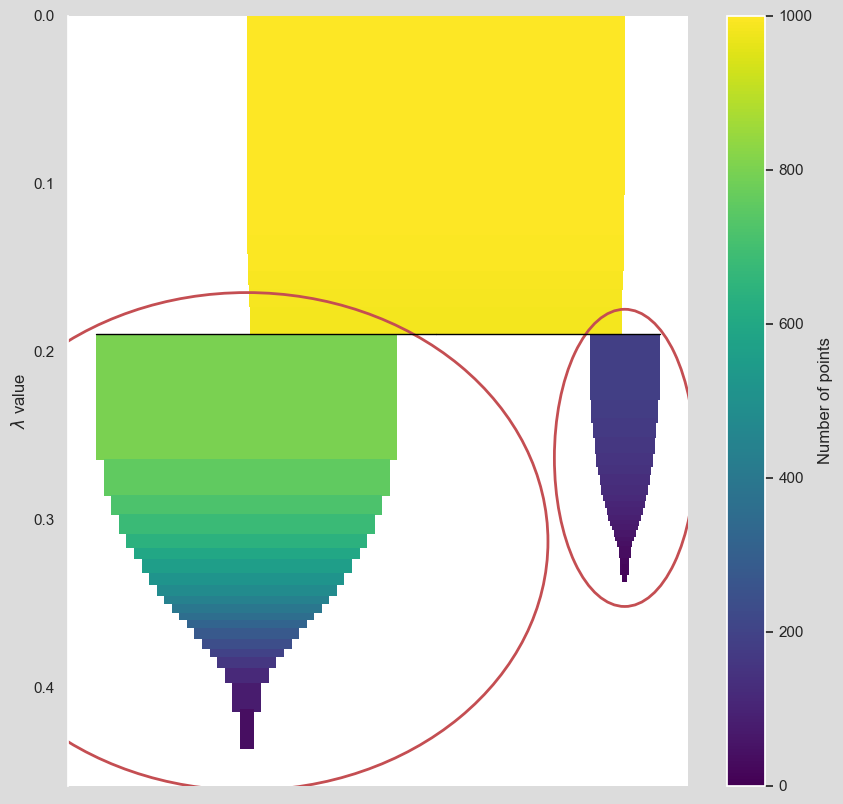

In [70]:
hdbscan_red_plot = hdbscan_red.condensed_tree_.plot(select_clusters=True)
plt.savefig('hdbscan_red_plot.png')

In [71]:
data_clust_reduced['cluster_hdbscan_red'] = hdbscan_red.labels_

In [72]:
data_clust_reduced['cluster_hdbscan_red'].value_counts()

cluster_hdbscan_red
 0    797
 1    186
-1     17
Name: count, dtype: int64

In [73]:
set_config(transform_output="pandas")

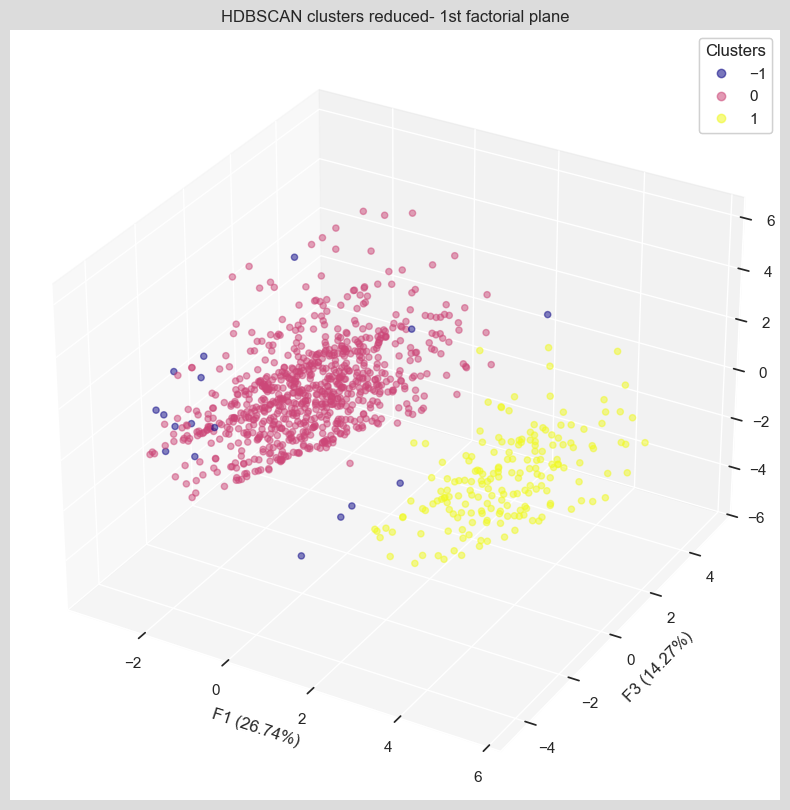

In [74]:
sns.set(rc={'figure.figsize':(10, 10), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})

# plot clusters in 1st factorial plane
# pca_kmeans = PCA(n_components=4)
# pca_kmeans.fit(X_scaled)

X_proj = pca_kmeans_red.transform(X_reduced)
X_proj.rename(columns={'pca0':'PC1','pca1':'PC2','pca2':'PC3','pca3':'PC4'}, inplace=True)

# use initialised scaler 
# centroids_6_scaled = std_scaler.fit_transform(centroids_6)
# centroids_6_scaled = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(centroids_km_6)

# use initialised acp 
# centroids_6_proj = pca_kmeans.transform(centroids_6_scaled)
# centroids_6_proj.rename(columns={'pca0':'F1','pca1':'F2','pca2':'F3','pca3':'F4'}, inplace=True)
# centroids_6_proj.rename(index={0: 'cluster_1', '1':'cluster_2','2':'cluster_3','3':'cluster_4','4':'cluster_5',
#                                '5':'cluster_6'}, inplace=True)

# plot results
# fig, ax = plt.subplots(1,1) 

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], X_proj.iloc[:, 2], c= data_clust_reduced['cluster_hdbscan_red'], 
                     cmap="plasma", alpha =0.5)


# ax.scatter(centroids_6_proj.iloc[:, 0], centroids_6_proj.iloc[:, 1],  marker="x",
#                       c=['maroon', 'blue', 'blueviolet', 'orange', 'fuchsia', 'dimgrey'])

ax.set_xlabel('F{} ({}%)'.format(1,round(100*pca_kmeans_red.explained_variance_ratio_[0],2)))
ax.set_ylabel('F{} ({}%)'.format(2,round(100*pca_kmeans_red.explained_variance_ratio_[1],2)))
ax.set_ylabel('F{} ({}%)'.format(3,round(100*pca_kmeans_red.explained_variance_ratio_[2],2)))

# plot thicker abscissa and ordinate lines
# plt.axvline(x=0, c='gainsboro', lw=1, linestyle='solid')
# plt.axhline(y=0, c='gainsboro', lw=1, linestyle='solid')

# produce a legend with the unique colors from the scatter
legend_1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend_1)

ax.set_title("HDBSCAN clusters reduced- 1st factorial plane")
plt.grid(axis='both', color='gainsboro', lw=0.5)
plt.savefig("HDBSCAN  clusters reduced - 1st factorial plane.png", bbox_inches='tight')
plt.show()

**HDBSCAN also returns only 2 clusters. Again, this is not good enough to characterise customers from a marketing and business perspective.**

## 3.5- Affinity propagation

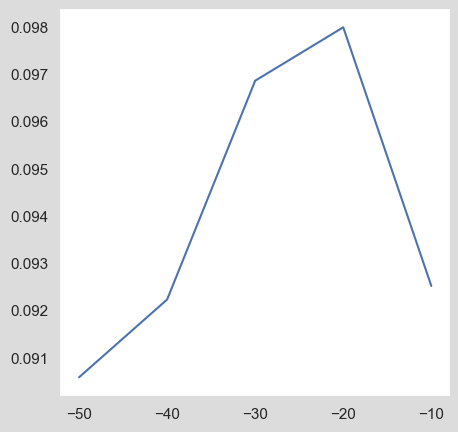

In [75]:
# find best number of clusters
Preference = [-50, -40, -30, -20, -10]
silhouette_scores_ap = []
for preference in Preference:
    model = AffinityPropagation(preference=preference, random_state=42)
    model.fit(X_reduced)
    silhouette_scores_ap.append(silhouette_score(X_reduced, model.labels_))
silhouette_scores_ap

# create line plot of `Preference` vs `silhouette_scores`
sns.set(rc={'figure.figsize':(5, 5), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
plt.plot(Preference , silhouette_scores_ap)
plt.grid()
plt.show()

**Silhouette score is maximised for preference = -20.**

In [76]:
# Compute Affinity Propagation 
af = AffinityPropagation(preference=-20, random_state=42).fit(X_reduced)
cluster_centers_indices = af.cluster_centers_indices_
labels_af = af.labels_
  
n_clusters_ = len(cluster_centers_indices)

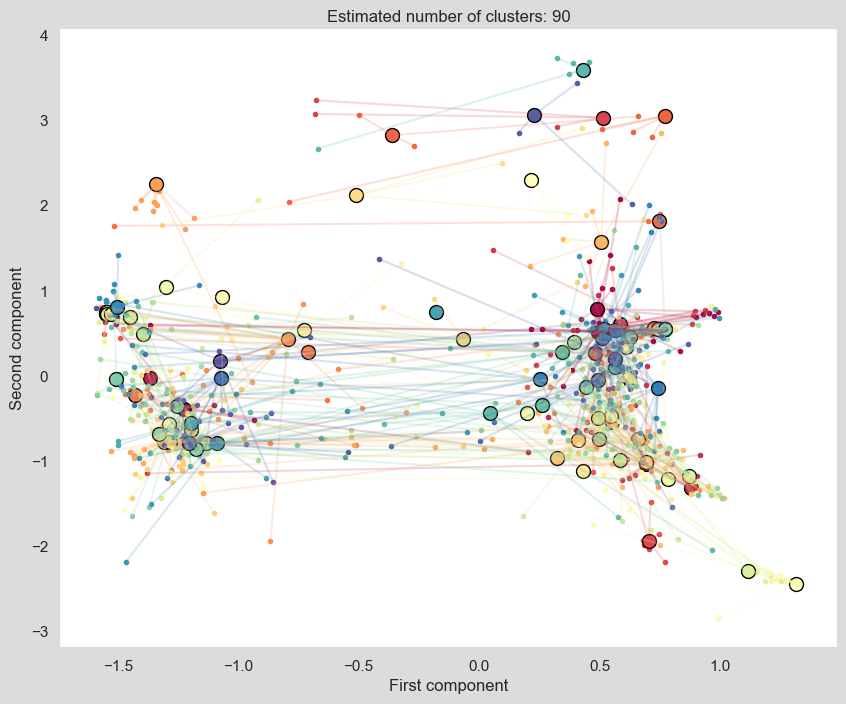

In [77]:
n_clusters_ = len(cluster_centers_indices)

# create a color map
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters_))

plt.figure(figsize=(10, 8))

# plot all points
plt.scatter(X_reduced.iloc[:, 0], X_reduced.iloc[:, 1],
            marker='.', s=10, color='k', alpha=0.1)

# plot each cluster
for k, col in zip(range(n_clusters_), colors):
    class_members = labels_af == k
    cluster_center = X_reduced.iloc[cluster_centers_indices[k]]
    
    plt.scatter(X_reduced.iloc[class_members, 0], X_reduced.iloc[class_members, 1], 
                color=col, marker='.')
    
    plt.scatter(cluster_center[0], cluster_center[1],
                s=100, color=col, marker='o', edgecolors='black')
    
    for x in X_reduced.iloc[class_members].values:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col, alpha=0.2)

plt.title(f'Estimated number of clusters: {n_clusters_}')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.show()

**The affinity propagation model returns a number of clusters that is way too high for any useful and comprehensible interpretation from a marketing and business perspective.**

## 3.6 - K-prototypes

**NOTE : the K-Prototypes algorithm is no longer useful here, as pre-clustered data X_reduced does not contain anymore categorical data after further feature elimination.**

### 3.6.1 - Determine optimal number of clusters - Elbow method

In [78]:
# X_kp = data.drop(labels=['customer_id', 'last_order_date', 'state'], axis=1)
# X_kp.info()

# get indices of category columns
# catcol_idx = [X_kp.columns.get_loc(col) for col in list(X_kp.select_dtypes("category").columns)]
# catcol_idx

In [79]:
# X_kp.info()

In [80]:
# cost=[]

# k_list_5 = range(2, 9)

# for k in k_list_5:
    # kp = KPrototypes(n_clusters=k, init='random', verbose=1, max_iter=2, n_init=2, random_state=42, n_jobs=-1)
    # kp = KPrototypes(n_clusters=k, init='random', max_iter=10, n_init=10, verbose=1, random_state=42)
    # kp = KPrototypes(n_clusters=k, init='Cao', max_iter=10, n_init=10, verbose=1, random_state=42)
    # kp = KPrototypes(n_clusters=k, init='Huang', max_iter=10, n_init=10, verbose=1, random_state=42)
    # kp_clusters = kp.fit_predict(X_kp, categorical=catcol_idx) 
    # kp_clusters = kproto.fit_predict([X_num, X_cat]) 
    # cost.append(kp.cost_)
    
# plot wcss curve
# fig, ax = plt.subplots(1,1,figsize=(5,3))
# ax.set_ylabel('Cost function')
# ax.set_xlabel('Number of clusters')
# ax.set_title('Cost function vs. number of clusters', fontsize=12, fontweight='bold')
# ax = plt.plot(k_list_5, cost, color=cherry)
# plt.xticks(np.arange(min(k_list_5), max(k_list_5)+1, 1.0))
# plt.grid(axis='both', color='gainsboro')
# plt.savefig('kproto_elbow.png', bbox_inches='tight')
# plt.show()

In [81]:
# knee_5 = KneeLocator(range(2,9), cost, S=0.1, curve="convex", direction="decreasing")
# knee_k_5 = knee_5.elbow   
# print("elbow at k =", f'{knee_k_5:.0f} clusters')

In [82]:
# cost

In [83]:
# knee_5b = KneeLocator(range(4,9), cost[2:9], S=0.1, curve="convex", direction="decreasing")
# knee_k_5b = knee_5b.elbow   
# print("elbow at k =", f'{knee_k_5b:.0f} clusters')

### 3.6.2 - K-prototypes with 3 clusters

In [84]:
# Running K-Prototype clustering
# kproto_3 = KPrototypes(n_clusters=3, init='random', random_state=42, max_iter=2, n_init=2, verbose=1) 
# kproto_3.fit_predict(X_kp, categorical=catcol_idx)

# labels_kproto_3 = kproto_3.labels_

# add cluster number to each customer in clusters dataframe
# data_clust['cluster_kproto_3'] = (kproto_3.labels_ + 1)

# print number of customers in each cluster
# cluster_kproto_3_1 = data_clust.loc[data_clust['cluster_kproto_3'] == 1]['customer_id'].count()
# print('Nb of customers in 1st cluster :', cluster_kproto_3_1)
# cluster_kproto_3_2 = data_clust.loc[data_clust['cluster_kproto_3'] == 2]['customer_id'].count()
# print('Nb of customers in 2nd cluster :', cluster_kproto_3_2)
# cluster_kproto_3_3 = data_clust.loc[data_clust['cluster_kproto_3'] == 3]['customer_id'].count()
# print('Nb of customers in 3rd cluster :', cluster_kproto_3_3)

In [85]:
# sns.set(rc={'figure.figsize':(10, 10), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})

# plot clusters in 1st factorial plane
# pca_kmeans = PCA(n_components=4)
# pca_kmeans.fit(X_scaled)

# X_proj = pca_kmeans.transform(X_scaled)
# X_proj.rename(columns={'pca0':'PC1','pca1':'PC2','pca2':'PC3','pca3':'PC4'}, inplace=True)

# use initialised scaler 
# centroids_6_scaled = std_scaler.fit_transform(centroids_6)
# centroids_6_scaled = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(centroids_km_6)

# use initialised acp 
# centroids_6_proj = pca_kmeans.transform(centroids_6_scaled)
# centroids_6_proj.rename(columns={'pca0':'F1','pca1':'F2','pca2':'F3','pca3':'F4'}, inplace=True)
# centroids_6_proj.rename(index={0: 'cluster_1', '1':'cluster_2','2':'cluster_3','3':'cluster_4','4':'cluster_5',
#                                '5':'cluster_6'}, inplace=True)

# plot results
# fig, ax = plt.subplots(1,1) 
# scatter = ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= data_clust['cluster_kproto_3'], cmap="Set1", alpha =0.1)
# ax.scatter(centroids_6_proj.iloc[:, 0], centroids_6_proj.iloc[:, 1],  marker="x",
#                       c=['maroon', 'blue', 'blueviolet', 'orange', 'fuchsia', 'dimgrey'])

# ax.set_xlabel('F{} ({}%)'.format(1,round(100*pca.explained_variance_ratio_[0],2)))
# ax.set_ylabel('F{} ({}%)'.format(2,round(100*pca.explained_variance_ratio_[1],2)))

# plot thicker abscissa and ordinate lines
# plt.axvline(x=0, c='gainsboro', lw=1, linestyle='solid')
# plt.axhline(y=0, c='gainsboro', lw=1, linestyle='solid')

# produce a legend with the unique colors from the scatter
# legend_1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
# ax.add_artist(legend_1)

# ax.set_title("KPrototypes 3 clusters - 1st factorial plane")
# plt.grid(axis='both', color='gainsboro', lw=0.5)
# plt.savefig("KPrototypes 3 clusters - 1st factorial plane.png", bbox_inches='tight')
# plt.show()

**-Centroids analysis:**

In [86]:
# centroids_kproto_3 = kproto_3.cluster_centroids_
# centroids_kp_3 = pd.DataFrame(centroids_kproto_3)
# centroids_kp_3.columns = X_kp.columns
# centroids_kp_3

In [87]:
# plot polar chart centroids
# categories = centroids_kp_3.columns
# fig = go.Figure()
# fig.add_trace(go.Scatterpolar(r=centroids_kp_3.iloc[0], theta=categories, fill='toself', name='Cluster 1 centroid'))
# fig.add_trace(go.Scatterpolar(r=centroids_kp_3.iloc[1], theta=categories, fill='toself', name='Cluster 2 centroid'))
# fig.add_trace(go.Scatterpolar(r=centroids_kp_3.iloc[2], theta=categories, fill='toself', name='Cluster 3 centroid'))

# fig.update_traces(opacity=0.5, selector=dict(type='scatterpolar'))
# fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, centroids_km_4.max().max()])),showlegend=True)
# fig.write_image("centroids_radar.png")
# fig.show()

### 3.6.3 - K-prototypes with 5 clusters

In [88]:
# Running K-Prototype clustering
# kproto_5 = KPrototypes(n_clusters=5, init='random', random_state=42, max_iter=2, n_init=2, verbose=1) 
# kproto_5.fit_predict(X_kp, categorical=catcol_idx)

# labels_kproto_5 = kproto_5.labels_

# add cluster number to each customer in clusters dataframe
# data_clust['cluster_kproto_5'] = (kproto_5.labels_ + 1)

# print number of customers in each cluster
# cluster_kproto_5_1 = data_clust.loc[data_clust['cluster_kproto_5'] == 1]['customer_id'].count()
# print('Nb of customers in 1st cluster :', cluster_kproto_5_1)
# cluster_kproto_5_2 = data_clust.loc[data_clust['cluster_kproto_5'] == 2]['customer_id'].count()
# print('Nb of customers in 2nd cluster :', cluster_kproto_5_2)
# cluster_kproto_5_3 = data_clust.loc[data_clust['cluster_kproto_5'] == 3]['customer_id'].count()
# print('Nb of customers in 3rd cluster :', cluster_kproto_5_3)
# cluster_kproto_5_4 = data_clust.loc[data_clust['cluster_kproto_5'] == 4]['customer_id'].count()
# print('Nb of customers in 4th cluster :', cluster_kproto_5_4)
# cluster_kproto_5_5 = data_clust.loc[data_clust['cluster_kproto_5'] == 5]['customer_id'].count()
# print('Nb of customers in 5th cluster :', cluster_kproto_5_5)
# cluster_kproto_6_6 = data_clust.loc[data_clust['cluster_kproto_6'] == 6]['customer_id'].count()
# print('Nb of customers in 6th cluster :', cluster_kproto_6_6)

In [89]:
# sns.set(rc={'figure.figsize':(10, 10), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})

# plot clusters in 1st factorial plane
# pca_kmeans = PCA(n_components=4)
# pca_kmeans.fit(X_scaled)

# X_proj = pca_kmeans.transform(X_scaled)
# X_proj.rename(columns={'pca0':'PC1','pca1':'PC2','pca2':'PC3','pca3':'PC4'}, inplace=True)

# use initialised scaler 
# centroids_6_scaled = std_scaler.fit_transform(centroids_6)
# centroids_6_scaled = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(centroids_km_6)

# use initialised acp 
# centroids_6_proj = pca_kmeans.transform(centroids_6_scaled)
# centroids_6_proj.rename(columns={'pca0':'F1','pca1':'F2','pca2':'F3','pca3':'F4'}, inplace=True)
# centroids_6_proj.rename(index={0: 'cluster_1', '1':'cluster_2','2':'cluster_3','3':'cluster_4','4':'cluster_5',
#                                '5':'cluster_6'}, inplace=True)

# plot results
# fig, ax = plt.subplots(1,1) 
# scatter = ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= data_clust['cluster_kproto_6'], cmap="Set1", alpha =0.1)
# ax.scatter(centroids_6_proj.iloc[:, 0], centroids_6_proj.iloc[:, 1],  marker="x",
#                       c=['maroon', 'blue', 'blueviolet', 'orange', 'fuchsia', 'dimgrey'])

# ax.set_xlabel('F{} ({}%)'.format(1,round(100*pca.explained_variance_ratio_[0],2)))
# ax.set_ylabel('F{} ({}%)'.format(2,round(100*pca.explained_variance_ratio_[1],2)))

# plot thicker abscissa and ordinate lines
# plt.axvline(x=0, c='gainsboro', lw=1, linestyle='solid')
# plt.axhline(y=0, c='gainsboro', lw=1, linestyle='solid')

# produce a legend with the unique colors from the scatter
# legend_1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
# ax.add_artist(legend_1)

# ax.set_title("KPrototypes 6 clusters - 1st factorial plane")
# plt.grid(axis='both', color='gainsboro', lw=0.5)
# plt.savefig("KPrototypes 6 clusters - 1st factorial plane.png", bbox_inches='tight')
# plt.show()

**-Centroids analysis:**

In [90]:
# centroids_kproto_5 = kproto_5.cluster_centroids_
# centroids_kp_5 = pd.DataFrame(centroids_kproto_5)
# centroids_kp_5.columns = X_kp.columns
# centroids_kp_5

In [91]:
# plot polar chart centroids
# categories = centroids_kp_5.columns
# fig = go.Figure()
# fig.add_trace(go.Scatterpolar(r=centroids_kp_5.iloc[0], theta=categories, fill='toself', name='Cluster 1 centroid'))
# fig.add_trace(go.Scatterpolar(r=centroids_kp_5.iloc[1], theta=categories, fill='toself', name='Cluster 2 centroid'))
# fig.add_trace(go.Scatterpolar(r=centroids_kp_5.iloc[2], theta=categories, fill='toself', name='Cluster 3 centroid'))
# fig.add_trace(go.Scatterpolar(r=centroids_kp_5.iloc[3], theta=categories, fill='toself', name='Cluster 4 centroid'))
# fig.add_trace(go.Scatterpolar(r=centroids_kp_5.iloc[2], theta=categories, fill='toself', name='Cluster 5 centroid'))
# fig.add_trace(go.Scatterpolar(r=centroids_kp_5.iloc[3], theta=categories, fill='toself', name='Cluster 6 centroid'))

# fig.update_traces(opacity=0.5, selector=dict(type='scatterpolar'))
# fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, centroids_km_5.max().max()])),showlegend=True)
# fig.write_image("centroids_radar.png")
# fig.show()

## 3.7 - K-means on full dataset

**As K-means clustering gives us a reasonable number of clusters (not too low & not too high), let us now run this model and characterise our customer clusters on the full, not pre-clustered, dataset.**

In [92]:
# create dataframe for clustering analysis
data_clust = data_trim.copy()
data_clust.head(1)

customer_id  altitude  pop_density  motor_vehicles  \
0  00012a2ce6f8dcda20d059ce98491703  742.9664        30.51          3282.0   

   GDP_per_capita  post_offices  tax_gdp_%  nb_of_orders  total_spent  \
0        6556.155           1.0       4.04           1.0         89.8   

   total_freight  total_products  product_weight_avg  review_score_avg  \
0          24.94             1.0              4267.0               1.0   

   shipping_distance_avg last_order_date  delivery_timeframe_avg  \
0             120.134678      2017-11-14                    17.0   

   last_order_age_in_days  average_basket  purchase_frequency  
0                   288.0            89.8                 0.5

In [93]:
# create dataframe for map
data_map_sca = data[['customer_id', 'c_lat', 'c_lon']]

### 3.7.1 - K-means with 4 clusters

In [94]:
# run K-means
kmeans_4_sca = KMeans(n_clusters=4, init='k-means++', copy_x=True, algorithm='lloyd', n_init='auto', max_iter=300, verbose=0,
                      random_state=42)
kmeans_4_sca.fit(X_scaled)
labels_4_sca = kmeans_4_sca.labels_

# add cluster number to each customer in clusters dataframe
data_clust['cluster_kmean_4_sca'] = (kmeans_4_sca.labels_ + 1)
# add cluster number to each customer in map dataframe
data_map_sca['cluster_kmean_4_sca'] = (kmeans_4_sca.labels_ + 1)

# print number of customers in each cluster
cluster_4_1_sca = data_clust.loc[data_clust['cluster_kmean_4_sca'] == 1]['customer_id'].count()
print('Nb of customers in 1st cluster :', cluster_4_1_sca)
cluster_4_2_sca = data_clust.loc[data_clust['cluster_kmean_4_sca'] == 2]['customer_id'].count()
print('Nb of customers in 2nd cluster :', cluster_4_2_sca)
cluster_4_3_sca = data_clust.loc[data_clust['cluster_kmean_4_sca'] == 3]['customer_id'].count()
print('Nb of customers in 3rd cluster :', cluster_4_3_sca)
cluster_4_4_sca = data_clust.loc[data_clust['cluster_kmean_4_sca'] == 4]['customer_id'].count()
print('Nb of customers in 4th cluster :', cluster_4_4_sca)

print('Total customers :', (cluster_4_1_sca + cluster_4_2_sca + cluster_4_3_sca + cluster_4_4_sca))

Nb of customers in 1st cluster : 28928
Nb of customers in 2nd cluster : 12486
Nb of customers in 3rd cluster : 27886
Nb of customers in 4th cluster : 26040
Total customers : 95340


### 3.7.2 - Centroids analysis

In [95]:
centroids_4_sca = kmeans_4_sca.cluster_centers_
centroids_km_4_sca = pd.DataFrame(centroids_4_sca)
centroids_km_4_sca.columns = features
centroids_km_4_sca

num__altitude  num__pop_density  num__motor_vehicles  num__GDP_per_capita  \
0       0.570365          0.180687             0.421637             0.439067   
1       0.006033          0.009452             0.000738             0.000558   
2      -0.022788          0.199244             0.483028             0.303422   
3      -0.611867         -0.418363            -0.985227            -0.812208   

   num__post_offices  num__tax_gdp_%  num__nb_of_orders  num__total_spent  \
0           0.073608       -0.310115          -0.388184         -0.676171   
1          -0.023947       -0.017056           2.576088          0.552916   
2           0.530293        0.489154          -0.388184          0.600926   
3          -0.636868       -0.170667          -0.388184         -0.156555   

   num__total_freight  num__total_products  num__product_weight_avg  \
0           -0.822301            -0.388184                -0.483259   
1            1.113248             2.576088                 0.016453   
2            0.389671            -0.388184                 0.552146   
3           -0.036836            -0.388184                -0.061578   

   num__review_score_avg  num__shipping_distance_avg  \
0               0.148707                   -0.721046   
1              -0.262375                   -0.014388   
2              -0.014134                    0.429285   
3              -0.023847                    0.348646   

   num__delivery_timeframe_avg  num__last_order_age_in_days  \
0                    -0.704715                    -0.159251   
1                     0.011533                     0.051607   
2                     0.372397                     0.062630   
3                     0.378948                     0.085180   

   num__average_basket  num__purchase_frequency  
0            -0.567685                -0.388184  
1            -0.231444                 2.576555  
2             0.729932                -0.388184  
3            -0.039162                -0.388184

In [96]:
centroids_km_4_sca.index

RangeIndex(start=0, stop=4, step=1)

In [97]:
# plot polar chart centroids
categories = centroids_km_4_sca.columns
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=centroids_km_4_sca.iloc[0], theta=categories, fill='toself', name='Cluster 1 centroid'))
fig.add_trace(go.Scatterpolar(r=centroids_km_4_sca.iloc[1], theta=categories, fill='toself', name='Cluster 2 centroid'))
fig.add_trace(go.Scatterpolar(r=centroids_km_4_sca.iloc[2], theta=categories, fill='toself', name='Cluster 3 centroid'))
fig.add_trace(go.Scatterpolar(r=centroids_km_4_sca.iloc[3], theta=categories, fill='toself', name='Cluster 4 centroid'))
fig.update_traces(opacity=0.5, selector=dict(type='scatterpolar'))
fig.show()

### 3.7.3 - Graphical representation of clusters

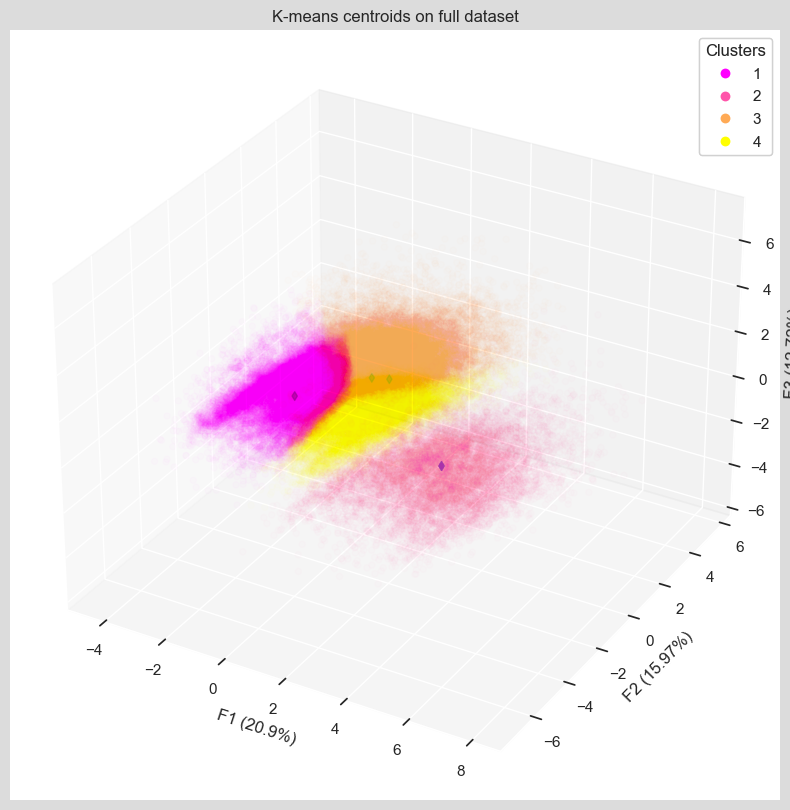

In [98]:
# define plotting style
sns.set(rc={'figure.figsize': (10, 10), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})
spring_palette = []

# initialize PCA
pca_kmeans_sca = PCA(n_components=3)
pca_kmeans_sca.fit(X_scaled)  # Fit PCA on the scaled data

# transform the scaled data into PCA space
X_proj_sca = pca_kmeans_sca.transform(X_scaled)

# rename the columns of the transformed data for better readability
X_proj_sca.rename(columns={'pca0': 'PC1', 'pca1': 'PC2', 'pca2': 'PC3'}, inplace=True)

# transform centroids of K-means clusters into PCA space
centroids_4_proj_sca = pca_kmeans_sca.transform(centroids_km_4_sca)

# rename the columns of the centroids for clarity
centroids_4_proj_sca.rename(columns={'pca0': 'F1', 'pca1': 'F2', 'pca2': 'F3'}, inplace=True)

# rename the index of centroids to represent cluster names
centroids_4_proj_sca.rename(index={'0': 'cluster_1', '1': 'cluster_2', '2': 'cluster_3', '3': 'cluster_4'}, inplace=True)

# create a new figure for a 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')  # Add a 3D subplot

# create a scatter plot for the projected data points in PCA space, colored by cluster
scatter = ax.scatter(X_proj_sca.iloc[:, 0], X_proj_sca.iloc[:, 1], X_proj_sca.iloc[:, 2],
                     c=data_clust['cluster_kmean_4_sca'], cmap="spring", alpha=0.01)  # Set transparency to see overlapping points

# scatter plot for K-means centroids, using diamond markers with specified colors and edge colors
ax.scatter(centroids_4_proj_sca.iloc[:, 0], centroids_4_proj_sca.iloc[:, 1], marker="d",
           c=['purple', 'darkorchid', 'chartreuse', 'maroon'], 
           edgecolors=['purple', 'darkorchid', 'chartreuse', 'maroon'])

# set labels for each axis, including explained variance ratios for PCA components
ax.set_xlabel('F{} ({}%)'.format(1, round(100 * pca_kmeans_sca.explained_variance_ratio_[0], 2)))  # Label for PC1
ax.set_ylabel('F{} ({}%)'.format(2, round(100 * pca_kmeans_sca.explained_variance_ratio_[1], 2)))  # Label for PC2
ax.set_zlabel('F{} ({}%)'.format(3, round(100 * pca_kmeans_sca.explained_variance_ratio_[2], 2)))  # Label for PC3

# create a legend for clusters based on scatter plot elements
legend_1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")

# set the alpha of each legend handle to 1 (fully opaque) for better visibility
for lh in legend_1.legend_handles:
    lh.set_alpha(1.0)  # Make each legend handle fully opaque

# add the legend to the axes
ax.add_artist(legend_1)

# set a title for the plot
ax.set_title("K-means centroids on full dataset")

# add grid lines to the plot for better readability, with specified color and line width
plt.grid(axis='both', color='gainsboro', lw=0.5)

# save the figure as a PNG file with tight bounding box to avoid clipping
plt.savefig("Kmeans centroids on full dataset.png", bbox_inches='tight')

# Extract and display hex codes of colors used in plotting clusters from spring cmap
num_clusters = len(data_clust['cluster_kmean_4_sca'].unique())
spring_cmap = sns.color_palette("spring", num_clusters)

# print("Hex codes of cluster colors:")
for color in spring_cmap:
    hex_code = mcolors.to_hex(color)
    spring_palette.append(hex_code)
    # print(hex_code)

# display the plot
plt.show()


### 3.7.4 - RFM analysis of clusters

RFM analysis, which stands for Recency, Frequency, and Monetary value, is a marketing technique used to evaluate customer behavior based on three key metrics:

1. **Recency (R)**: How recently a customer has made a purchase.
2. **Frequency (F)**: How often a customer makes a purchase within a specific timeframe.
3. **Monetary Value (M)**: How much money a customer spends during that timeframe.

It provides a structured approach to understanding customer behavior and enables businesses to implement data-driven marketing strategies that enhance customer relationships and drive revenue growth.


### Relevance for Customer Segmentation

RFM analysis is considered highly relevant for customer segmentation for several reasons:

- **Targeted Marketing**: By segmenting customers based on their purchasing behavior, businesses can tailor marketing strategies to specific groups, increasing the effectiveness of campaigns and improving response rates.

- **Identifying Valuable Customers**: It helps identify high-value customers who contribute significantly to revenue, allowing businesses to focus their efforts on retaining these customers.

- **Enhancing Customer Loyalty**: Personalized marketing messages derived from RFM insights can strengthen customer loyalty and engagement, leading to increased customer lifetime value.

- **Proactive Retention Strategies**: RFM analysis can pinpoint at-risk customers, enabling businesses to take proactive measures to retain them before they churn.

In order to further evaluate the K-Means clustering results, we will perform tests to assess the statistical significance of the RFM differences between the clusters. As none of the numerical variables used for clustering follow a normal distribution, non-parametric tests will be used:  
- **Kruskal-Wallis Test**  
The Kruskal-Wallis test is a non-parametric method used to determine if there are statistically significant differences between the medians of three or more independent groups. Since K-means clustering does not assume any specific distribution of the data, using a non-parametric test like Kruskal-Wallis is appropriate when the data are not Gaussian.  
- **Dunn's Post-Hoc Test**  
If the Kruskal-Wallis test indicates significant differences among the clusters, Dunn's test can be used as a post-hoc analysis to identify which specific clusters differ from each other. Dunn's test is designed for pairwise comparisons and is also non-parametric, making it suitable for data that do not meet the assumptions of normality.

In [99]:
# Create dataframe with relevant columns for RFM analysis of clusters
data_clust_rfm = data_clust[['customer_id', 'total_spent', 'total_freight','total_products','last_order_age_in_days',
                             'average_basket', 'purchase_frequency', 'cluster_kmean_4_sca' ]]

#### 3.7.4.1 - Recency

**- Clusters boxplot:**

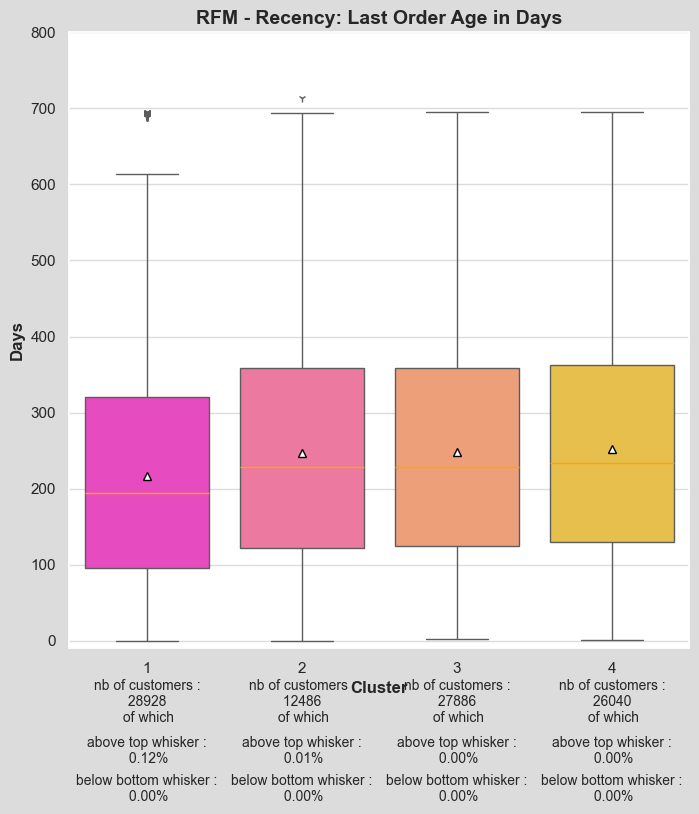

In [100]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
spring_cmap = sns.color_palette("spring", 4)

# Create the boxplot for last_order_age_in_days
kmeans_box_last_order_age = sns.boxplot(data=data_clust_rfm, x="cluster_kmean_4_sca", y="last_order_age_in_days", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=spring_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('Days', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(-10, 800)  # Adjust limits if necessary based on last_order_age_in_days data
plt.title('RFM - Recency: Last Order Age in Days', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_rfm.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -50, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using last_order_age_in_days
    Q1 = data_clust_rfm[data_clust_rfm['cluster_kmean_4_sca'] == cluster]['last_order_age_in_days'].quantile(0.25)
    Q3 = data_clust_rfm[data_clust_rfm['cluster_kmean_4_sca'] == cluster]['last_order_age_in_days'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_rfm[(data_clust_rfm['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_rfm['last_order_age_in_days'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_rfm[(data_clust_rfm['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_rfm['last_order_age_in_days'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -125, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -175, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_last_order_age.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in last_order_age_in_days:**

In [101]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_1 = [group['last_order_age_in_days'].values for name, group in data_clust_rfm.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_1, p_value_1 = st.kruskal(*grouped_data_1)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_1}")
print(f"P-value: {p_value_1}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
alpha = 0.05  # significance level

if p_value_1 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_1 = sp.posthoc_dunn(data_clust_rfm, val_col='last_order_age_in_days', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_1)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 970.4640609931115
P-value: 4.594976822291521e-210
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
               1             2              3              4
1   1.000000e+00  3.427280e-78  2.905484e-136  3.207166e-166
2   3.427280e-78  1.000000e+00   1.000000e+00   1.135788e-02
3  2.905484e-136  1.000000e+00   1.000000e+00   1.433398e-02
4  3.207166e-166  1.135788e-02   1.433398e-02   1.000000e+00


**All pairs of clusters have significant p-values at the threshold alpha=5%, except clusters 2 and 3, which do not significantly differ in last_order_age_in_days.**

#### 3.7.4.2 - Frequency

**- Clusters boxplot:**

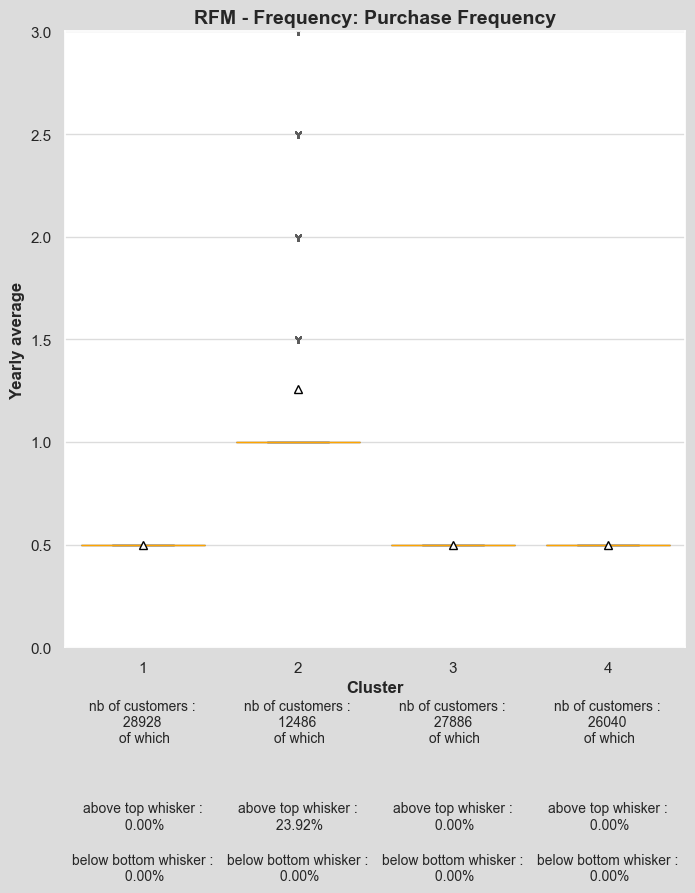

In [102]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("spring", 4)

# Create the boxplot for purchase_frequency
kmeans_box_purchase_frequency = sns.boxplot(data=data_clust_rfm, x="cluster_kmean_4_sca", y="purchase_frequency", 
                                             hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                             medianprops={"color": "orange"},
                                             meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                             orient="v", palette=spring_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('Yearly average', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(0, 3)  # Adjust limits if necessary based on purchase_frequency data
plt.title('RFM - Frequency: Purchase Frequency', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_rfm.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -0.25, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using purchase_frequency
    Q1 = data_clust_rfm[data_clust_rfm['cluster_kmean_4_sca'] == cluster]['purchase_frequency'].quantile(0.25)
    Q3 = data_clust_rfm[data_clust_rfm['cluster_kmean_4_sca'] == cluster]['purchase_frequency'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_rfm[(data_clust_rfm['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_rfm['purchase_frequency'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_rfm[(data_clust_rfm['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_rfm['purchase_frequency'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -0.75, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -1, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_purchase_frequency.png", bbox_inches='tight')
plt.show()

**- Statistical significance of cluster differences in purchase_frequency:**

In [103]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_2 = [group['purchase_frequency'].values for name, group in data_clust_rfm.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_2, p_value_2 = st.kruskal(*grouped_data_2)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_2}")
print(f"P-value: {p_value_2}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_2 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_2 = sp.posthoc_dunn(data_clust_rfm, val_col='purchase_frequency', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_2)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 94990.52414864606
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
     1    2    3    4
1  1.0  0.0  1.0  1.0
2  0.0  1.0  0.0  0.0
3  1.0  0.0  1.0  1.0
4  1.0  0.0  1.0  1.0


**Only cluster 2 has significant p-values at the threshold alpha=5%, and therefore significantly differs in purchase_frequency from the other clusters.**

#### 3.7.4.3 - Monetary

**- Clusters boxplot for total amount spent:**

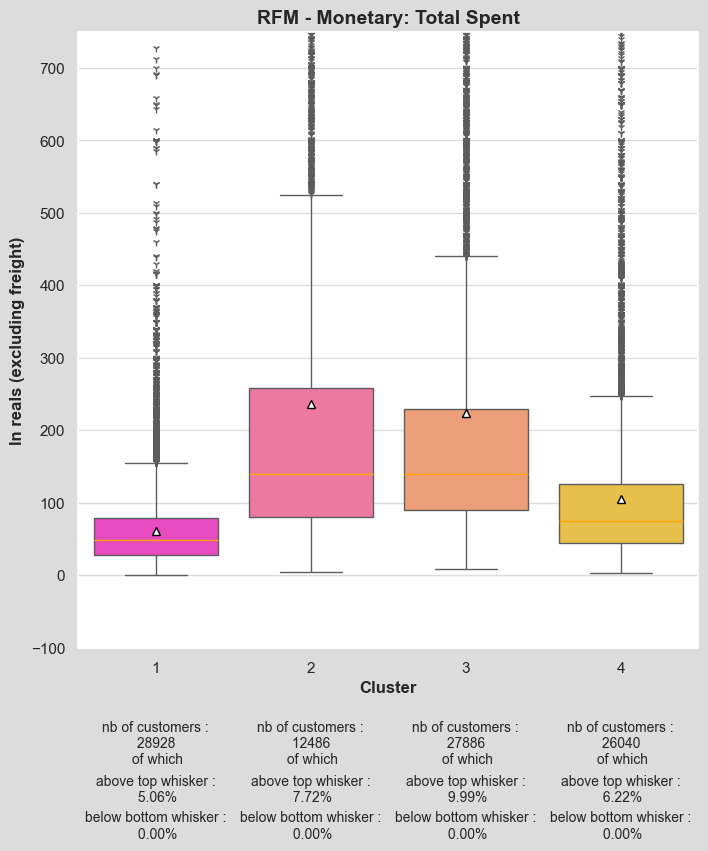

In [104]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("spring", 4)

# Create the boxplot
kmeans_box_total_spent = sns.boxplot(data=data_clust_rfm, x="cluster_kmean_4_sca", y="total_spent", 
                                     hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                     medianprops={"color": "orange"},
                                     meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                     orient="v", palette=spring_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('In reals (excluding freight)', fontweight='bold', fontsize=12)
plt.ylim(-100, 750)
plt.title('RFM - Monetary: Total Spent', fontweight='bold', fontsize=14)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_rfm.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -200, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster
    Q1 = data_clust_rfm[data_clust_rfm['cluster_kmean_4_sca'] == cluster]['total_spent'].quantile(0.25)
    Q3 = data_clust_rfm[data_clust_rfm['cluster_kmean_4_sca'] == cluster]['total_spent'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_rfm[(data_clust_rfm['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_rfm['total_spent'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_rfm[(data_clust_rfm['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_rfm['total_spent'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -275, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -325, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_total_spent.png", bbox_inches='tight')
plt.show()

**- Statistical significance of cluster differences in amount_spent:**

In [105]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_3 = [group['total_spent'].values for name, group in data_clust_rfm.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_3, p_value_3 = st.kruskal(*grouped_data_3)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_3}")
print(f"P-value: {p_value_3}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_3 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_3 = sp.posthoc_dunn(data_clust_rfm, val_col='total_spent', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_3)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 28836.842805688204
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
     1             2             3    4
1  1.0  0.000000e+00  0.000000e+00  0.0
2  0.0  1.000000e+00  4.102793e-09  0.0
3  0.0  4.102793e-09  1.000000e+00  0.0
4  0.0  0.000000e+00  0.000000e+00  1.0


**All pairs of clusters have significant p-values at the threshold alpha=5%, and therefore significantly differ in total_amount_spent.**

**- Clusters boxplot for total freight expenses:**

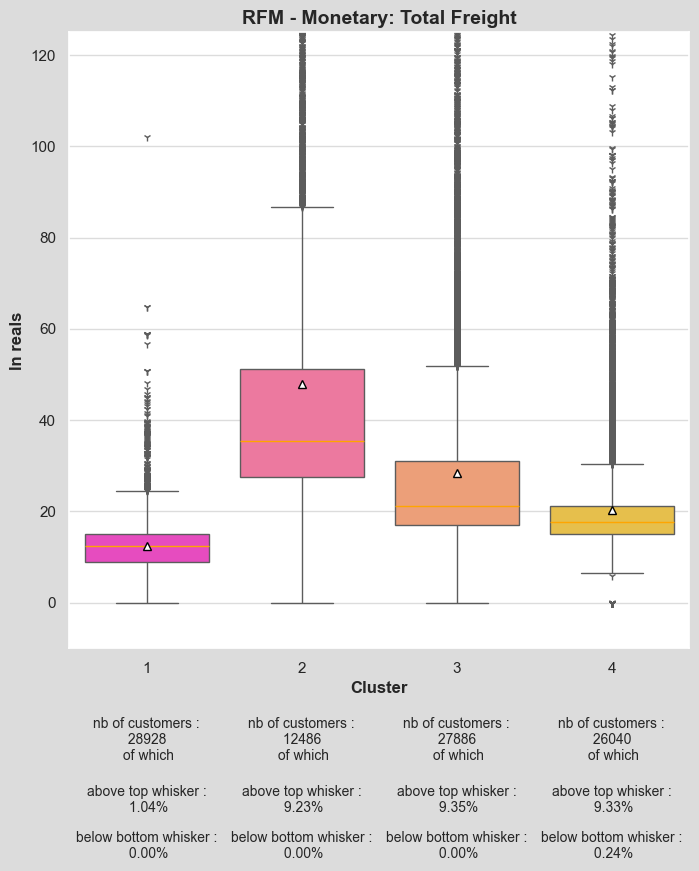

In [106]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("spring", 4)

# Create the boxplot
kmeans_box_total_freight = sns.boxplot(data=data_clust_rfm, x="cluster_kmean_4_sca", y="total_freight", 
                                        hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                        medianprops={"color": "orange"},
                                        meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                        orient="v", palette=spring_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('In reals', fontweight='bold', fontsize=12)
plt.ylim(-10, 125)
plt.title('RFM - Monetary: Total Freight', fontweight='bold', fontsize=14)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_rfm.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -25, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster
    Q1 = data_clust_rfm[data_clust_rfm['cluster_kmean_4_sca'] == cluster]['total_freight'].quantile(0.25)
    Q3 = data_clust_rfm[data_clust_rfm['cluster_kmean_4_sca'] == cluster]['total_freight'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_rfm[(data_clust_rfm['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_rfm['total_freight'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_rfm[(data_clust_rfm['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_rfm['total_freight'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -40, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -50, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_total_freight.png", bbox_inches='tight')
plt.show()

**- Statistical significance of cluster differences in freight expenses:**

In [107]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_4 = [group['total_freight'].values for name, group in data_clust_rfm.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_4, p_value_4 = st.kruskal(*grouped_data_4)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_4}")
print(f"P-value: {p_value_4}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_4 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_4 = sp.posthoc_dunn(data_clust_rfm, val_col='total_freight', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_4)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 49230.331015797165
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
     1    2    3    4
1  1.0  0.0  0.0  0.0
2  0.0  1.0  0.0  0.0
3  0.0  0.0  1.0  0.0
4  0.0  0.0  0.0  1.0


**All pairs of clusters have significant p-values at the threshold alpha=5%, and therefore significantly differ in total_freignt.**

**- Clusters boxplot for average basket:**

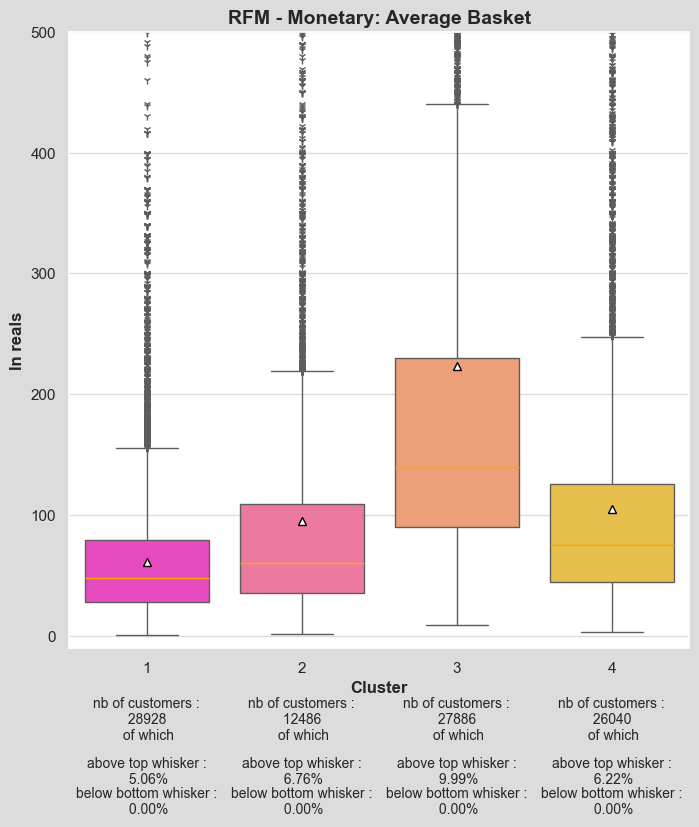

In [108]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("spring", 4)

# Create the boxplot for average_basket
kmeans_box_average_basket = sns.boxplot(data=data_clust_rfm, x="cluster_kmean_4_sca", y="average_basket", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=spring_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('In reals', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(-10, 500)  # Adjust limits if necessary based on average_basket data
plt.title('RFM - Monetary: Average Basket', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_rfm.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -50, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using average_basket
    Q1 = data_clust_rfm[data_clust_rfm['cluster_kmean_4_sca'] == cluster]['average_basket'].quantile(0.25)
    Q3 = data_clust_rfm[data_clust_rfm['cluster_kmean_4_sca'] == cluster]['average_basket'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_rfm[(data_clust_rfm['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_rfm['average_basket'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_rfm[(data_clust_rfm['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_rfm['average_basket'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -100, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -125, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_average_basket.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in average_basket:**

In [109]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_5 = [group['average_basket'].values for name, group in data_clust_rfm.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_5, p_value_5 = st.kruskal(*grouped_data_5)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_5}")
print(f"P-value: {p_value_5}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_5 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_5 = sp.posthoc_dunn(data_clust_rfm, val_col='average_basket', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_5)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 25864.88632154805
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
               1              2    3             4
1   1.000000e+00  4.459233e-225  0.0  0.000000e+00
2  4.459233e-225   1.000000e+00  0.0  9.049314e-72
3   0.000000e+00   0.000000e+00  1.0  0.000000e+00
4   0.000000e+00   9.049314e-72  0.0  1.000000e+00


**All pairs of clusters have significant p-values at the threshold alpha=5%, and therefore significantly differ in average basket.**

**- Clusters boxplot for total number of different products purchased:**

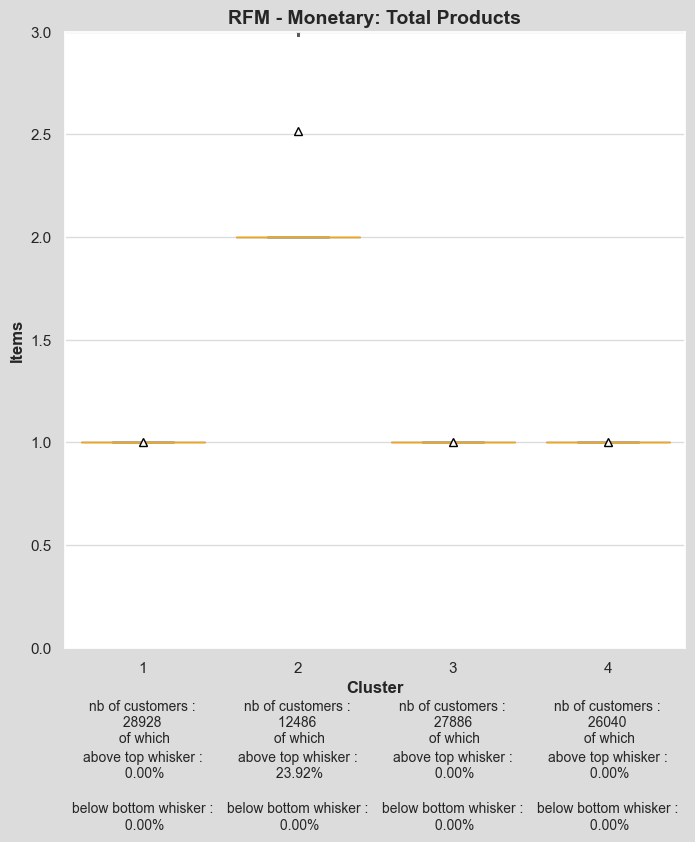

In [110]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("spring", 4)

# Create the boxplot for total_products
kmeans_box_total_products = sns.boxplot(data=data_clust_rfm, x="cluster_kmean_4_sca", y="total_products", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=spring_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('Items', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(0, 3)  # Adjust limits if necessary based on total_products data
plt.title('RFM - Monetary: Total Products', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_rfm.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -0.25, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using total_products
    Q1 = data_clust_rfm[data_clust_rfm['cluster_kmean_4_sca'] == cluster]['total_products'].quantile(0.25)
    Q3 = data_clust_rfm[data_clust_rfm['cluster_kmean_4_sca'] == cluster]['total_products'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_rfm[(data_clust_rfm['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_rfm['total_products'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_rfm[(data_clust_rfm['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_rfm['total_products'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -0.5, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -0.75, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_total_products.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in total number of different products purchased:**

In [111]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_6 = [group['total_products'].values for name, group in data_clust_rfm.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_6, p_value_6 = st.kruskal(*grouped_data_6)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_6}")
print(f"P-value: {p_value_6}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_6 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_6 = sp.posthoc_dunn(data_clust_rfm, val_col='total_products', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_6)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 94990.52414864606
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
     1    2    3    4
1  1.0  0.0  1.0  1.0
2  0.0  1.0  0.0  0.0
3  1.0  0.0  1.0  1.0
4  1.0  0.0  1.0  1.0


**Only cluster 2 has significant p-values at the threshold alpha=5%, and therefore significantly differs in total number of different products purchased from the other clusters.**

### 3.7.5 - Analysis of clusters - other customer behaviour

In [112]:
# create dataframe
data_clust_ocb = data_clust[['customer_id', 'product_weight_avg', 'review_score_avg', 'cluster_kmean_4_sca']]

**- Clusters boxplot for product_weight_avg:**

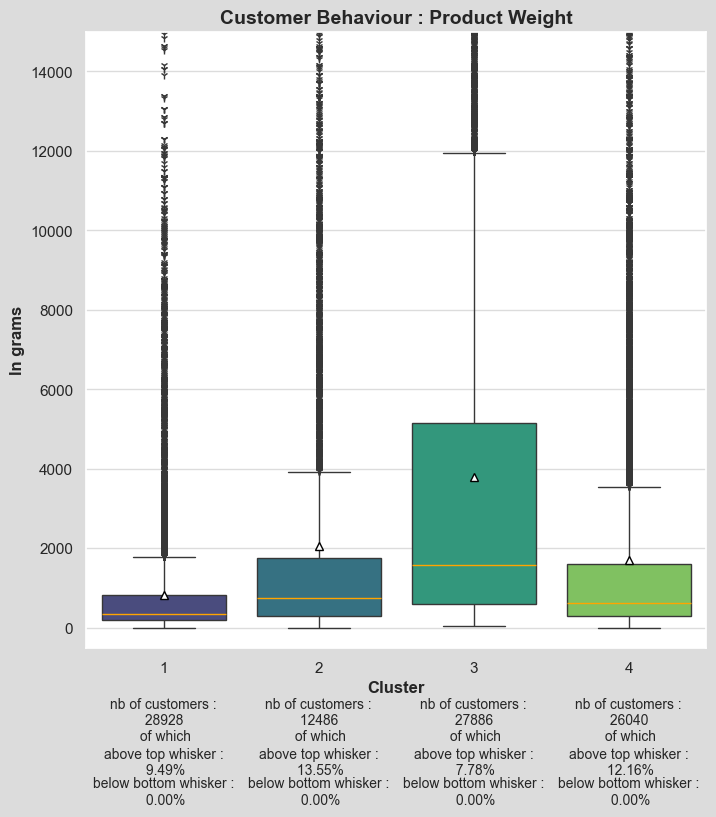

In [113]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from viridis with 4 distinct colors
vir_cmap = sns.color_palette("viridis", 4)

# Create the boxplot for average_basket
kmeans_product_weight_avg = sns.boxplot(data=data_clust_ocb, x="cluster_kmean_4_sca", y="product_weight_avg", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=vir_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('In grams', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(-500, 15000)  # Adjust limits if necessary based on average_basket data
plt.title('Customer Behaviour : Product Weight', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_ocb.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -1750, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using average_basket
    Q1 = data_clust_ocb[data_clust_ocb['cluster_kmean_4_sca'] == cluster]['product_weight_avg'].quantile(0.25)
    Q3 = data_clust_ocb[data_clust_ocb['cluster_kmean_4_sca'] == cluster]['product_weight_avg'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_ocb[(data_clust_ocb['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_ocb['product_weight_avg'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_ocb[(data_clust_ocb['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_ocb['product_weight_avg'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -3000, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -3750, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_product_weight_avg.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in product_weight_avg:**

In [114]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_7 = [group['product_weight_avg'].values for name, group in data_clust_ocb.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_7, p_value_7 = st.kruskal(*grouped_data_7)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_7}")
print(f"P-value: {p_value_7}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_7 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_7 = sp.posthoc_dunn(data_clust_ocb, val_col='product_weight_avg', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_7)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 15219.387977581113
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
     1             2    3             4
1  1.0  0.000000e+00  0.0  0.000000e+00
2  0.0  1.000000e+00  0.0  9.269925e-13
3  0.0  0.000000e+00  1.0  0.000000e+00
4  0.0  9.269925e-13  0.0  1.000000e+00


**All pairs of clusters have significant p-values at the threshold alpha=5%, and therefore significantly differ in average weight of products purchased.**

**- Clusters boxplot for review_score_avg:**

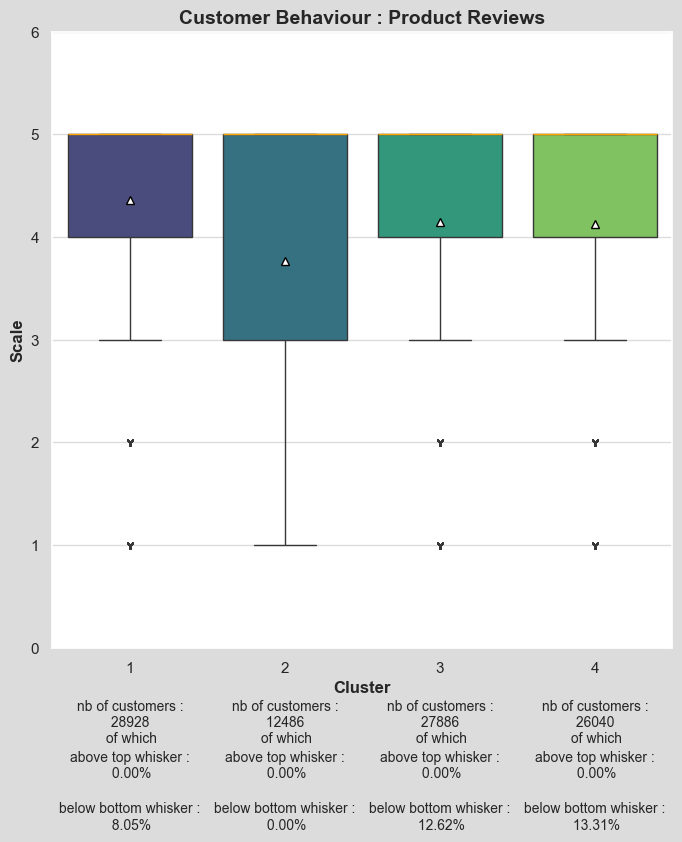

In [115]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("viridis", 4)

# Create the boxplot for average_basket
kmeans_review_score_avg = sns.boxplot(data=data_clust_ocb, x="cluster_kmean_4_sca", y="review_score_avg", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=vir_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('Scale', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(0, 6)  # Adjust limits if necessary based on average_basket data
plt.title('Customer Behaviour : Product Reviews', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_ocb.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -0.5, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using average_basket
    Q1 = data_clust_ocb[data_clust_ocb['cluster_kmean_4_sca'] == cluster]['review_score_avg'].quantile(0.25)
    Q3 = data_clust_ocb[data_clust_ocb['cluster_kmean_4_sca'] == cluster]['review_score_avg'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_ocb[(data_clust_ocb['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_ocb['review_score_avg'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_ocb[(data_clust_ocb['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_ocb['review_score_avg'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -1, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -1.5, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_review_score_avg.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in review_score_avg:**

In [116]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_8 = [group['review_score_avg'].values for name, group in data_clust_ocb.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_8, p_value_8 = st.kruskal(*grouped_data_8)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_8}")
print(f"P-value: {p_value_8}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_8 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_8 = sp.posthoc_dunn(data_clust_ocb, val_col='review_score_avg', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_8)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 1382.215605401827
P-value: 2.1292992718237426e-299
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
               1              2             3             4
1   1.000000e+00  2.673157e-290  7.381099e-82  1.009633e-85
2  2.673157e-290   1.000000e+00  1.980393e-99  1.049599e-91
3   7.381099e-82   1.980393e-99  1.000000e+00  1.000000e+00
4   1.009633e-85   1.049599e-91  1.000000e+00  1.000000e+00


**All clusters differ significantly in the average review score left by customers except clusters 3 and 4.**

### 3.7.6 - Analysis of clusters - customer economics & geography

In [117]:
# create dataframe
data_clust_eg = data_clust[['customer_id', 'altitude', 'pop_density', 'motor_vehicles', 'GDP_per_capita', 'post_offices',
                            'tax_gdp_%', 'shipping_distance_avg','delivery_timeframe_avg', 'cluster_kmean_4_sca']]

**- Clusters boxplot for altitude:**

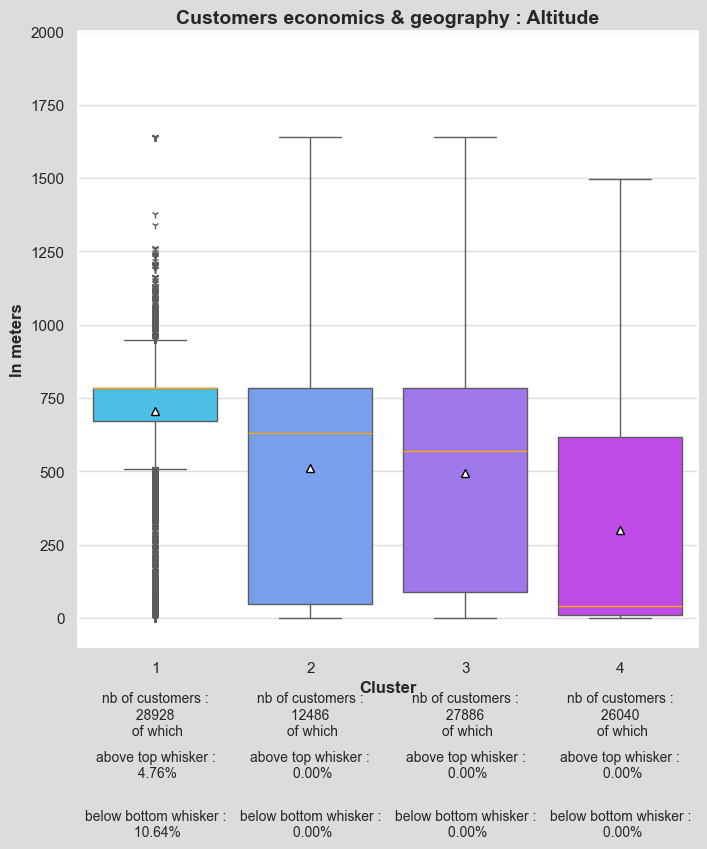

In [118]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
cool_cmap = sns.color_palette("cool", 4)

# Create the boxplot for average_basket
kmeans_review_score_avg = sns.boxplot(data=data_clust_eg, x="cluster_kmean_4_sca", y="altitude", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=cool_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('In meters', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(-100, 2000)  # Adjust limits if necessary based on average_basket data
plt.title('Customers economics & geography : Altitude', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_eg.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -250, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using average_basket
    Q1 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['altitude'].quantile(0.25)
    Q3 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['altitude'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['altitude'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['altitude'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -450, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -650, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_altitude_avg.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in altitude:**

In [119]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_9 = [group['altitude'].values for name, group in data_clust_eg.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_9, p_value_9 = st.kruskal(*grouped_data_9)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_9}")
print(f"P-value: {p_value_9}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_9 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_9 = sp.posthoc_dunn(data_clust_eg, val_col='altitude', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_9)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 15231.75887892142
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
     1             2             3    4
1  1.0  0.000000e+00  0.000000e+00  0.0
2  0.0  1.000000e+00  3.321087e-10  0.0
3  0.0  3.321087e-10  1.000000e+00  0.0
4  0.0  0.000000e+00  0.000000e+00  1.0


**All pairs of clusters have significant p-values at the threshold alpha=5%, and therefore significantly differ in average weight of products purchased.**

**- Clusters boxplot for pop_density:**

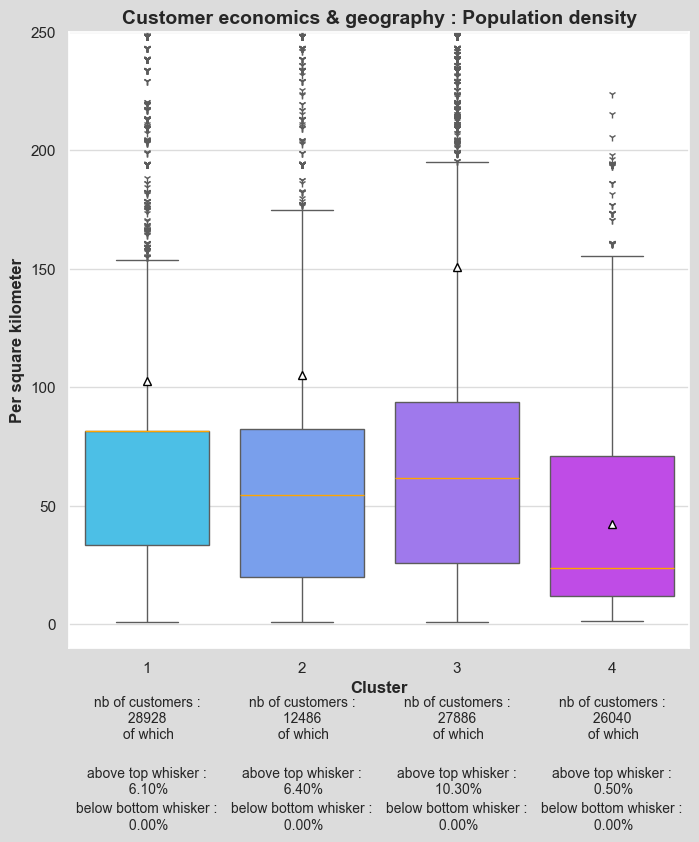

In [120]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("cool", 4)

# Create the boxplot for average_basket
kmeans_review_score_avg = sns.boxplot(data=data_clust_eg, x="cluster_kmean_4_sca", y="pop_density", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=cool_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('Per square kilometer', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(-10, 250)  # Adjust limits if necessary based on average_basket data
plt.title('Customer economics & geography : Population density', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_eg.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -30, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using average_basket
    Q1 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['pop_density'].quantile(0.25)
    Q3 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['pop_density'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['pop_density'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['pop_density'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -60, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -75, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_pop_density_avg.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in pop_density:**

In [121]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_10 = [group['pop_density'].values for name, group in data_clust_eg.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_10, p_value_10 = st.kruskal(*grouped_data_10)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_10}")
print(f"P-value: {p_value_10}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_10 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_10 = sp.posthoc_dunn(data_clust_eg, val_col='pop_density', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_10)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 5977.046619989081
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
              1              2             3              4
1  1.000000e+00   7.472524e-57  7.371653e-01   0.000000e+00
2  7.472524e-57   1.000000e+00  6.921279e-65  6.461204e-296
3  7.371653e-01   6.921279e-65  1.000000e+00   0.000000e+00
4  0.000000e+00  6.461204e-296  0.000000e+00   1.000000e+00


**All pairs of clusters have significant p-values at the threshold alpha=5%, except for clusters 1 and 3, and therefore they significantly differ in average population density.**

**- Clusters boxplot for motor_vehicles:**

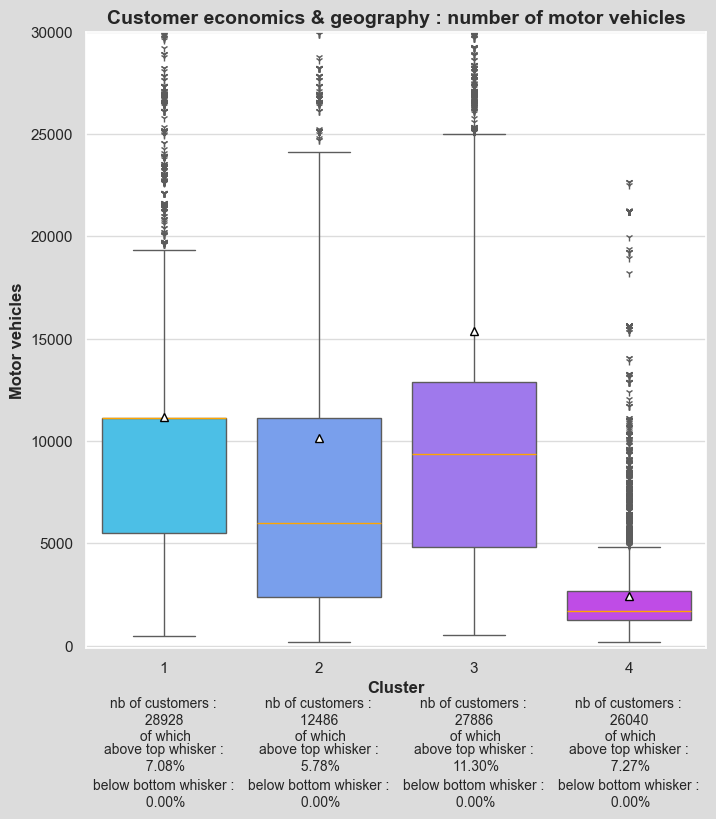

In [122]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("cool", 4)

# Create the boxplot for average_basket
kmeans_review_score_avg = sns.boxplot(data=data_clust_eg, x="cluster_kmean_4_sca", y="motor_vehicles", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=cool_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel("Motor vehicles", fontweight='bold', fontsize=12)  # Updated label
plt.ylim(-100, 30000)  # Adjust limits if necessary based on average_basket data
plt.title('Customer economics & geography : number of motor vehicles', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_eg.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -2500, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using average_basket
    Q1 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['motor_vehicles'].quantile(0.25)
    Q3 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['motor_vehicles'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['motor_vehicles'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['motor_vehicles'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -4750, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -6500, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_motor_vehicles_avg.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in motor_vehicles:**

In [123]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_11 = [group['motor_vehicles'].values for name, group in data_clust_eg.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_11, p_value_11 = st.kruskal(*grouped_data_11)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_11}")
print(f"P-value: {p_value_11}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_11 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_11 = sp.posthoc_dunn(data_clust_eg, val_col='motor_vehicles', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_11)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 37563.98312559023
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
          1    2         3    4
1  1.000000  0.0  0.594956  0.0
2  0.000000  1.0  0.000000  0.0
3  0.594956  0.0  1.000000  0.0
4  0.000000  0.0  0.000000  1.0


**All pairs of clusters have significant p-values at the threshold alpha=5%, except for clusters 1 and 3, and therefore they significantly differ in average population density.**

**- Clusters boxplot for GDP_per_capita:**

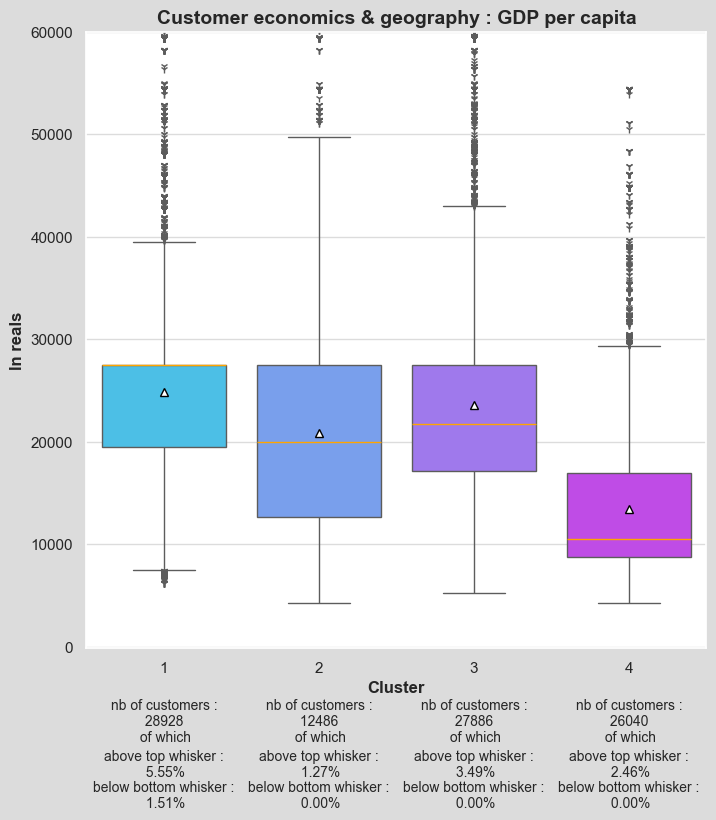

In [124]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("cool", 4)

# Create the boxplot for average_basket
kmeans_review_score_avg = sns.boxplot(data=data_clust_eg, x="cluster_kmean_4_sca", y="GDP_per_capita", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=cool_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('In reals', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(-100, 60000)  # Adjust limits if necessary based on average_basket data
plt.title('Customer economics & geography : GDP per capita', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_eg.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -5000, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using average_basket
    Q1 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['GDP_per_capita'].quantile(0.25)
    Q3 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['GDP_per_capita'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['GDP_per_capita'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['GDP_per_capita'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -10000, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -13000, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_GDP_per_capita_avg.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in GDP_per_capita:**

In [125]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_12 = [group['GDP_per_capita'].values for name, group in data_clust_eg.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_12, p_value_12 = st.kruskal(*grouped_data_12)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_12}")
print(f"P-value: {p_value_12}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_12 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_12 = sp.posthoc_dunn(data_clust_eg, val_col='GDP_per_capita', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_12)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 25942.759677427945
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
               1              2              3    4
1   1.000000e+00   0.000000e+00  2.413949e-136  0.0
2   0.000000e+00   1.000000e+00  1.769179e-132  0.0
3  2.413949e-136  1.769179e-132   1.000000e+00  0.0
4   0.000000e+00   0.000000e+00   0.000000e+00  1.0


**All pairs of clusters have significant p-values at the threshold alpha=5%, and therefore significantly differ in GDP per capita.**

**- Clusters boxplot for post_offices:**

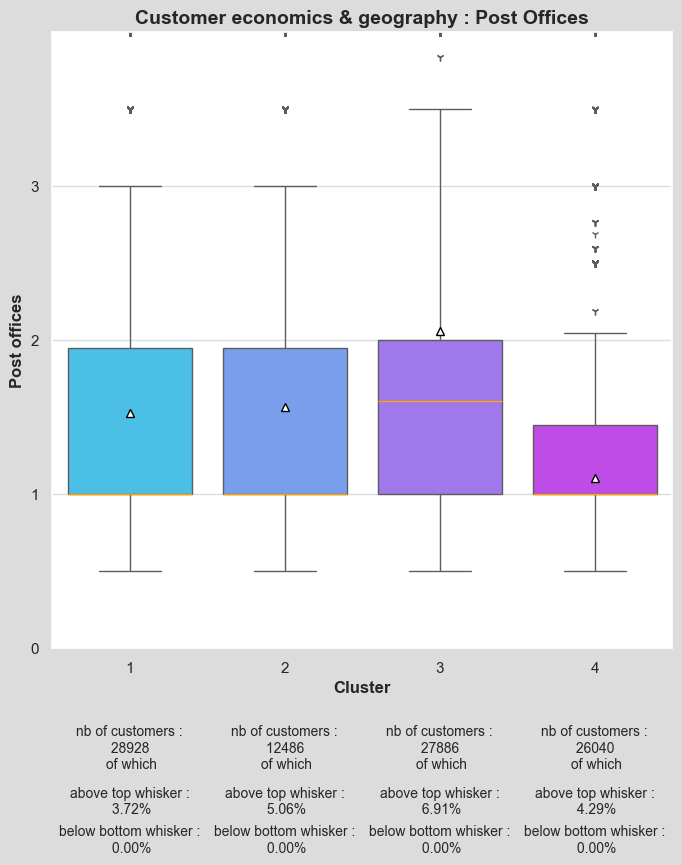

In [126]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("cool", 4)

# Create the boxplot for average_basket
kmeans_review_score_avg = sns.boxplot(data=data_clust_eg, x="cluster_kmean_4_sca", y="post_offices", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=cool_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('Post offices', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(0, 4)  # Adjust limits if necessary based on average_basket data
plt.yticks(np.arange(0, 4, 1))
plt.title('Customer economics & geography : Post Offices', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_eg.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -0.5, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using average_basket
    Q1 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['post_offices'].quantile(0.25)
    Q3 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['post_offices'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['post_offices'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['post_offices'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -0.90, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -1.15, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_post_offices_avg.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in post_offices:**

In [127]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_13 = [group['post_offices'].values for name, group in data_clust_eg.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_13, p_value_13 = st.kruskal(*grouped_data_13)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_13}")
print(f"P-value: {p_value_13}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_13 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_13 = sp.posthoc_dunn(data_clust_eg, val_col='post_offices', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_13)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 17142.353473735733
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
          1         2    3    4
1  1.000000  0.000003  0.0  0.0
2  0.000003  1.000000  0.0  0.0
3  0.000000  0.000000  1.0  0.0
4  0.000000  0.000000  0.0  1.0


**All pairs of clusters have significant p-values at the threshold alpha=5%, and therefore significantly differ in average number of post offices.**

**- Clusters boxplot for tax_gdp_%:**

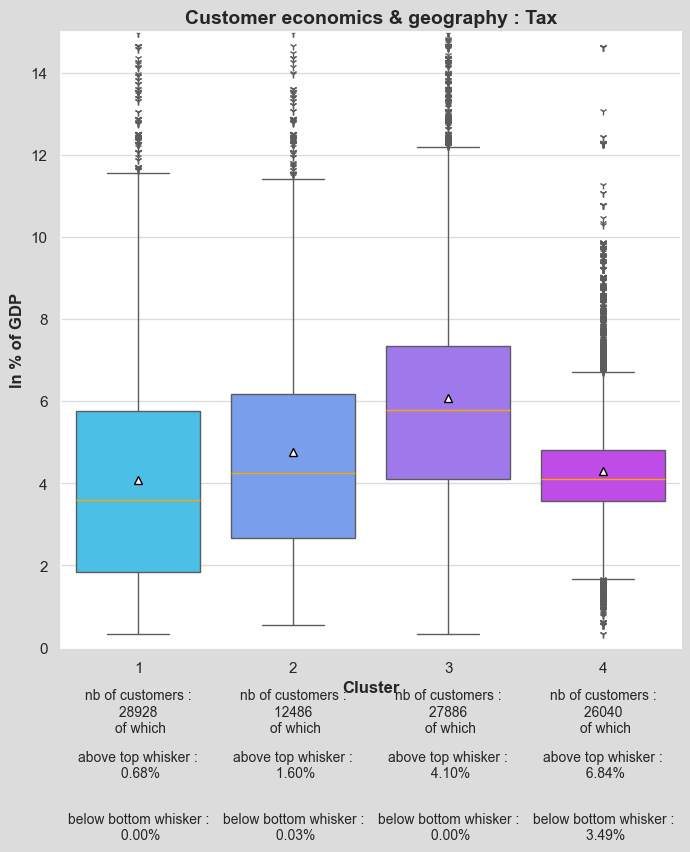

In [128]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("cool", 4)

# Create the boxplot for average_basket
kmeans_review_score_avg = sns.boxplot(data=data_clust_eg, x="cluster_kmean_4_sca", y="tax_gdp_%", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=cool_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('In % of GDP', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(0, 15)  # Adjust limits if necessary based on average_basket data
plt.title('Customer economics & geography : Tax', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_eg.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -1, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using average_basket
    Q1 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['tax_gdp_%'].quantile(0.25)
    Q3 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['tax_gdp_%'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['tax_gdp_%'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['tax_gdp_%'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -2.5, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -4, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_tax_gdp_%_avg.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in tax_gdp_%:**

In [129]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_14 = [group['tax_gdp_%'].values for name, group in data_clust_eg.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_14, p_value_14 = st.kruskal(*grouped_data_14)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_14}")
print(f"P-value: {p_value_14}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_14 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_14 = sp.posthoc_dunn(data_clust_eg, val_col='tax_gdp_%', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_14)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 10335.378985232908
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
               1              2    3             4
1   1.000000e+00  3.430363e-151  0.0  5.318973e-36
2  3.430363e-151   1.000000e+00  0.0  4.546417e-56
3   0.000000e+00   0.000000e+00  1.0  0.000000e+00
4   5.318973e-36   4.546417e-56  0.0  1.000000e+00


**All pairs of clusters have significant p-values at the threshold alpha=5%, and therefore significantly differ in average % of GDP paid in taxes.**

**- Clusters boxplot for shipping_distance_avg:**

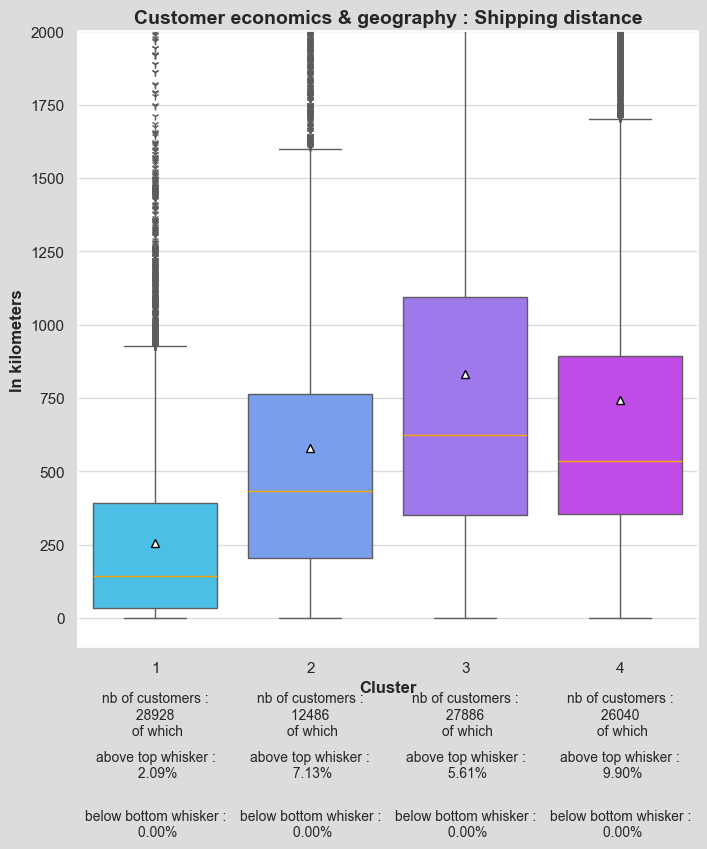

In [130]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("cool", 4)

# Create the boxplot for average_basket
kmeans_review_score_avg = sns.boxplot(data=data_clust_eg, x="cluster_kmean_4_sca", y="shipping_distance_avg", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=cool_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('In kilometers', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(-100, 2000)  # Adjust limits if necessary based on average_basket data
plt.title('Customer economics & geography : Shipping distance', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_eg.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -250, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using average_basket
    Q1 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['shipping_distance_avg'].quantile(0.25)
    Q3 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['shipping_distance_avg'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['shipping_distance_avg'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['shipping_distance_avg'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -450, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -650, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_shipping_distance_avg.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in shipping_distance_avg:**

In [131]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_15 = [group['shipping_distance_avg'].values for name, group in data_clust_eg.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_15, p_value_15 = st.kruskal(*grouped_data_15)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_15}")
print(f"P-value: {p_value_15}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_15 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_15 = sp.posthoc_dunn(data_clust_eg, val_col='shipping_distance_avg', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_15)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 22515.371731754552
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
     1              2             3              4
1  1.0   0.000000e+00  0.000000e+00   0.000000e+00
2  0.0   1.000000e+00  0.000000e+00  6.596066e-236
3  0.0   0.000000e+00  1.000000e+00   2.160002e-16
4  0.0  6.596066e-236  2.160002e-16   1.000000e+00


**All pairs of clusters have significant p-values at the threshold alpha=5%, and therefore significantly differ in average shipping distance of products purchased.**

**- Clusters boxplot for delivery_timeframe_avg:**

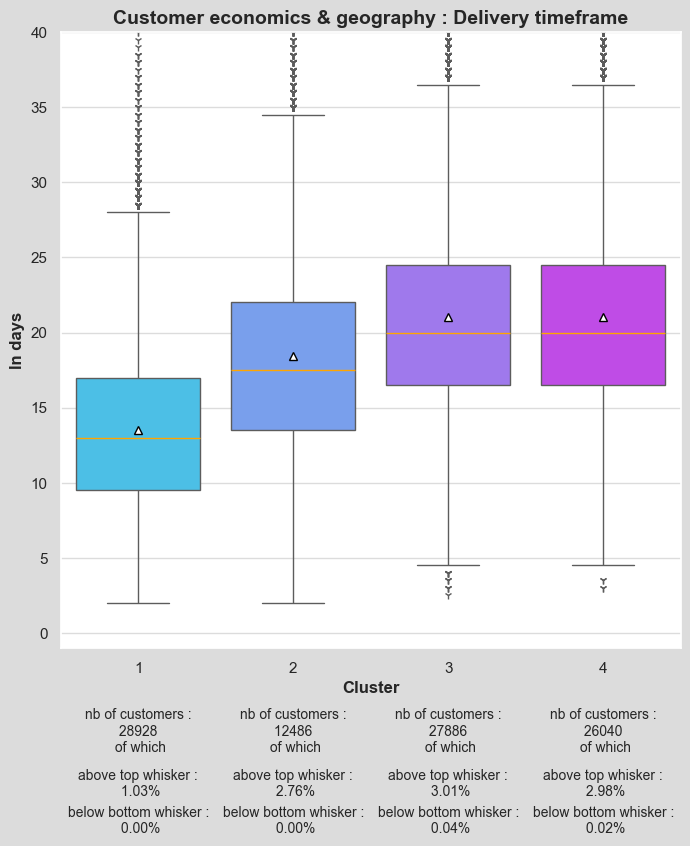

In [132]:
# Set aesthetics for the plot
sns.set(rc={'figure.figsize': (8, 8), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

# Create a colormap from spring with 4 distinct colors
# spring_cmap = sns.color_palette("cool", 4)

# Create the boxplot for average_basket
kmeans_delivery_timeframe_avg = sns.boxplot(data=data_clust_eg, x="cluster_kmean_4_sca", y="delivery_timeframe_avg", 
                                         hue="cluster_kmean_4_sca", flierprops={"marker": "1"}, 
                                         medianprops={"color": "orange"},
                                         meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, 
                                         orient="v", palette=cool_cmap, showmeans=True, dodge=False)

# Set labels and title
plt.xlabel('Cluster', fontweight='bold', fontsize=12)
plt.ylabel('In days', fontweight='bold', fontsize=12)  # Updated label
plt.ylim(-1, 40)  # Adjust limits if necessary based on average_basket data
plt.title('Customer economics & geography : Delivery timeframe', fontweight='bold', fontsize=14)  # Updated title
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# Calculate number of customers in each cluster
nb_cust = data_clust_eg.groupby('cluster_kmean_4_sca')['customer_id'].count().reset_index()

# Add number of customers below each cluster
for i in range(len(nb_cust)):
    plt.text(i, -5, "nb of customers :\n {} \n of which".format(nb_cust.iloc[i, 1]), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Calculate whisker limits and percentages for individuals above and below them
for i, cluster in enumerate(nb_cust['cluster_kmean_4_sca']):
    # Calculate Q1, Q3, and IQR for the current cluster using average_basket
    Q1 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['delivery_timeframe_avg'].quantile(0.25)
    Q3 = data_clust_eg[data_clust_eg['cluster_kmean_4_sca'] == cluster]['delivery_timeframe_avg'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine upper and lower whisker limits
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    
    # Count number of individuals above the upper whisker
    num_above_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['delivery_timeframe_avg'] > upper_whisker)])
    
    # Count number of individuals below the lower whisker
    num_below_whisker = len(data_clust_ocb[(data_clust_eg['cluster_kmean_4_sca'] == cluster) & 
                                             (data_clust_eg['delivery_timeframe_avg'] < lower_whisker)])
    
    # Calculate percentages relative to number of customers in this cluster
    percentage_above_whisker = (num_above_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    percentage_below_whisker = (num_below_whisker / nb_cust.iloc[i, 1]) * 100 if nb_cust.iloc[i, 1] > 0 else 0
    
    # Display the percentage above the whisker for each cluster
    plt.text(i, -9, "above top whisker :\n {:.2f}%".format(percentage_above_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

    # Display the percentage below the whisker for each cluster
    plt.text(i, -11.5, "below bottom whisker :\n {:.2f}%".format(percentage_below_whisker), 
             horizontalalignment='center', verticalalignment='top', fontsize=10)

# Save and show the plot
plt.savefig("kmeans_box_delivery_timeframe_avg.png", bbox_inches='tight')
plt.show()


**- Statistical significance of cluster differences in delivery_timeframe_avg:**

In [133]:
# Group the data by cluster and extract the last_order_age_in_days for each cluster
grouped_data_16 = [group['delivery_timeframe_avg'].values for name, group in data_clust_eg.groupby('cluster_kmean_4_sca')]

# Perform the Kruskal-Wallis test
statistic_16, p_value_16 = st.kruskal(*grouped_data_16)

# Output the results of Kruskal-Wallis test
print(f"Kruskal-Wallis H-statistic: {statistic_16}")
print(f"P-value: {p_value_16}")

# Proceed with Dunn's test if Kruskal-Wallis test is significant
# alpha = 0.05  # significance level

if p_value_16 < alpha:
    print("There are significant differences between the clusters.")
    
    # Perform Dunn's post-hoc test
    dunn_results_16 = sp.posthoc_dunn(data_clust_eg, val_col='delivery_timeframe_avg', group_col='cluster_kmean_4_sca',
                                     p_adjust='bonferroni')

    # Display Dunn's test results in a matrix format
    print("\nDunn's Test Results (Adjusted p-values):")
    print(dunn_results_16)
else:
    print("There are no significant differences between the clusters; Dunn's test is not performed.")


Kruskal-Wallis H-statistic: 22410.42737578309
P-value: 0.0
There are significant differences between the clusters.

Dunn's Test Results (Adjusted p-values):
     1              2              3              4
1  1.0   0.000000e+00   0.000000e+00   0.000000e+00
2  0.0   1.000000e+00  1.258948e-258  1.477284e-262
3  0.0  1.258948e-258   1.000000e+00   1.000000e+00
4  0.0  1.477284e-262   1.000000e+00   1.000000e+00


**All pairs of clusters have significant p-values at the threshold alpha=5%, except clusters 3 and 4, and therefore significantly differ in average delivery timeframe of products purchased.**

### 3.7.7 - Customers location

In [134]:
# Create dataframe with pre-clusters GPS information
data_map_red = data_clust_red.groupby('cluster_id_red').agg({'customer_id':'count', 'c_lat':'mean', 'c_lon':'mean'})
data_map_red.rename(columns={'customer_id':'nb_cust'}, inplace=True)
data_map_red.head()

nb_cust      c_lat      c_lon
cluster_id_red                               
0                    74 -23.400846 -45.222234
1                   122 -21.214519 -47.485965
2                   147 -22.466147 -47.610445
3                    56 -21.462925 -47.161216
4                   188 -23.491053 -46.695433

In [135]:
# Create a scatter plot on a geographic map using Plotly Express.
fig = px.scatter_geo(data_map_red,  # DataFrame containing the data for the map
                     lat='c_lat',  # Column name for latitude values
                     lon='c_lon',  # Column name for longitude values
                     size='nb_cust',  # Column name for the size of the markers (e.g., number of customers)
                     title=' ',  # Title of the plot (empty string for no title)
                     hover_name='nb_cust',  # Column to display when hovering over the markers
                     template='plotly',  # Plotly template for styling
                     scope='south america',  # Geographic scope of the map (South America)
                     # color=location_counts['client_count'],  # Optional: Column for marker color (commented out)
                     center={'lat': -28, 'lon': -55})  # Center the map at a specific latitude and longitude

# Update the layout of the figure to customize its appearance.
fig.update_layout(height=1000,  # Height of the plot in pixels
                  width=1000,  # Width of the plot in pixels
                  coloraxis_showscale=True,  # Show the color scale for the markers
                  paper_bgcolor='white',  # Background color of the plot area
                  margin=dict(t=80, r=10, l=10, b=10),  # Margins around the plot (top, right, left, bottom)
                  geo=dict(bgcolor='#AAE0FA', lakecolor='#65B1F7'),  # Background color of the map and lake color
                  title_x=0.5,  # Horizontal position of the title (0.5 for center)
                  title_y=0.977,  # Vertical position of the title
                  font=dict(size=15, color='#000000'),  # Font settings for the plot text
                  title=dict(font=dict(size=40, color='#000000')))  # Font settings for the plot title

# Save the plot as a PNG file.
fig.write_image("olist_pre-clusters_map.png")  # File name for the saved image

Color 1: #ff33cc
Color 2: #ff6699
Color 3: #ff9966
Color 4: #ffcc33


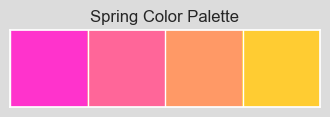

In [136]:
# Create a color palette from the spring colormap with 4 distinct colors
spring_cmap = sns.color_palette("spring", 4)

# Convert RGB tuples to hex codes
hex_codes = [mcolors.to_hex(color) for color in spring_cmap]

# Display the colors and their hex codes
for i, hex_code in enumerate(hex_codes):
    print(f"Color {i + 1}: {hex_code}")

# Visualize the color palette
sns.palplot(spring_cmap)
plt.title("Spring Color Palette")
plt.show()

In [137]:
# Define a color palette using Seaborn. In this case, using Spring color palette and setting the number of colors to 4
spring_cmap = sns.color_palette("spring", 4)
# Define a dictionary mapping cluster numbers to specific colors
cluster_colors = {1: '#ff33cc', 2: '#ff6699', 3: '#ff9966', 4: '#ffcc33'}

# Create a new column 'cluster_label' in the DataFrame 'data_map_sca'
# by mapping the numerical values in the 'cluster_kmean_4_sca' column to descriptive labels.
data_map_sca['cluster_label'] = data_map_sca['cluster_kmean_4_sca'].map({1: 'Cluster 1', 2: 'Cluster 2',
                                                                         3: 'Cluster 3', 4: 'Cluster 4'})

# Create a scatter plot on a geographic map using Plotly Express.
fig = px.scatter_geo(data_map_sca,  # DataFrame containing the data for the map
                     lat='c_lat',  # Column name for latitude values
                     lon='c_lon',  # Column name for longitude values
                     # size='nb_cust',  # Column name for the size of the markers (commented out in original code)
                     color='cluster_label',  # Column name to determine the color of the markers based on cluster
                     title='Customer Locations by Cluster',  # Title of the plot
                     # hover_name='nb_cust',  # Column to display when hovering over the markers (commented out in original code)
                     template='plotly',  # Plotly template for styling
                     scope='south america',  # Geographic scope of the map (South America)
                     center={'lat': -25, 'lon': -50},  # Center the map at a specific latitude and longitude
                     color_discrete_map=cluster_colors,  # Assign specific colors to each cluster label
                     opacity=0.1)  # Set the opacity of the markers

# Customize the layout of the plot.
fig.update_layout(height=1000,  # Height of the plot in pixels
                  width=1000,  # Width of the plot in pixels
                  coloraxis_showscale=False,  # Hide the color scale
                  paper_bgcolor='snow',  # Background color of the plot area
                  margin=dict(t=80, r=10, l=10, b=10),  # Margins around the plot (top, right, left, bottom)
                  geo=dict(bgcolor=ciel, lakecolor='gainsboro'),  # Background color of the map and lake color
                  title_x=0.5,  # Horizontal position of the title (0.5 for center)
                  title_y=0.975,  # Vertical position of the title
                  font=dict(size=15, color='snow'),  # Font settings for the plot text
                  title=dict(font=dict(size=40, color='dimgrey')),  # Font settings for the plot title
                  legend_title_text='Cluster',  # Title for the legend
                  legend=dict(x=0.70, y=0.75,  # Position of the legend (x and y coordinates)
                              xanchor='left',  # Anchor point for the legend's x position
                              yanchor='middle',  # Anchor point for the legend's y position
                              bgcolor=ciel,  # Background color of the legend
                              bordercolor=ciel,  # Border color of the legend
                              borderwidth=2))  # Border width of the legend

# Save the plot as a PNG file.
fig.write_image("olist_customer_map.png")  # File name for the saved image

## 3.8 - Analysis of cluster initialisation stability 

In [138]:
def calculate_clustering_stability(X, n_runs=20, n_clusters=4, batch_size=9534, max_iter=100):
    """
    Calculate the stability of clustering algorithms (K-Means and MiniBatchKMeans) 
    by running multiple clustering iterations and evaluating the consistency of the results 
    using the Adjusted Rand Index (ARI).

    Parameters:
    X : array-like, shape (n_samples, n_features)
        The input data to cluster.
        
    n_runs : int, optional (default=20)
        The number of times to run the clustering algorithms. More runs can provide 
        a better estimate of stability.
        
    n_clusters : int, optional (default=4)
        The number of clusters to form.
        
    batch_size : int, optional (default=9534)
        The size of the batches used in MiniBatchKMeans. This parameter controls 
        how many samples are processed at a time during training.
        
    max_iter : int, optional (default=100)
        The maximum number of iterations for the MiniBatchKMeans algorithm.

    Returns:
    tuple
        A tuple containing two elements:
        - avg_kmeans_stability : float
            The average stability score for K-Means across all runs based on ARI.
        - avg_minibatch_kmeans_stability : float
            The average stability score for MiniBatchKMeans across all runs based on ARI.
    """
    
    # Initialize lists to store labels from each run for both clustering methods
    kmeans_labels = []    
    minibatch_kmeans_labels = []

    # Run K-Means and MiniBatchKMeans multiple times to gather labels
    for run in range(n_runs):
        # K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=run)
        kmeans.fit(X)
        kmeans_labels.append(kmeans.labels_)
                      
        # MiniBatchKMeans clustering
        minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, max_iter=max_iter, random_state=run)
        minibatch_kmeans.fit(X)
        minibatch_kmeans_labels.append(minibatch_kmeans.labels_)

    # Lists to store stability scores for both clustering methods
    kmeans_stability = []
    minibatch_kmeans_stability = []

    # Calculate stability using Adjusted Rand Index (ARI) for all pairs of runs
    for i in range(n_runs):
        for j in range(i + 1, n_runs):
            # Calculate ARI for K-Means labels from different runs
            ari_kmeans = adjusted_rand_score(kmeans_labels[i], kmeans_labels[j])
            kmeans_stability.append(ari_kmeans)
                           
            # Calculate ARI for MiniBatchKMeans labels from different runs
            ari_minibatch_kmeans = adjusted_rand_score(minibatch_kmeans_labels[i], minibatch_kmeans_labels[j])
            minibatch_kmeans_stability.append(ari_minibatch_kmeans)

    # Calculate average stability scores across all pairs of runs
    avg_kmeans_stability = np.mean(kmeans_stability)
    avg_minibatch_kmeans_stability = np.mean(minibatch_kmeans_stability)

    return (avg_kmeans_stability, avg_minibatch_kmeans_stability)

In [140]:
# run function on full dataset
kmeans_sca, minik_sca = calculate_clustering_stability(X_scaled.values)
print(f'Average Adjusted Rand Index for K-Means: {kmeans_sca:.4f}')
print(f'Average Adjusted Rand Index for MiniBatchKMeans: {minik_sca:.4f}')

Average Adjusted Rand Index for K-Means: 0.8360
Average Adjusted Rand Index for MiniBatchKMeans: 0.4788


**MiniBatch KMeans can have lower clustering initialization stability compared to standard KMeans, primarily due to its use of random subsamples of the data in each iteration. There are several reasons for this:  
*- Random subsampling:* MiniBatch KMeans uses small random batches of the data in each iteration, which introduces variability in the clustering process. This randomness can lead to different results across multiple runs.  
*- Single initialization:* By default, MiniBatch KMeans uses a single initialization ("auto" or 1), unlike standard KMeans which typically uses multiple initializations. This reduces the chances of finding a globally optimal solution.  
*- Lack of convergence guarantee:* MiniBatch KMeans does not necessarily converge to a local optimum, as it uses subsamples of data repeatedly rather than the full dataset. This can result in less stable final cluster assignments.  
*-Sensitivity to initialization:* The algorithm's performance can be sensitive to the initial centroids, especially with a single initialization. This sensitivity is amplified by the use of random subsamples.  
*-Trade-off between speed and accuracy:* MiniBatch KMeans sacrifices some accuracy and stability for increased speed. This trade-off can result in slightly different results compared to standard KMeans.  
To improve stability, one can increase the batch size, use multiple initializations (n_init parameter), or increase the number of iterations (max_iter parameter). However, these adjustments may reduce the speed advantage of MiniBatch KMeans over standard KMeans.**

**K-Means: ARI = 0.8360
This score indicates a strong level of agreement between the clustering results from different runs of the K-Means algorithm. An ARI of 0.8360 suggests that K-Means is stable across multiple runs, meaning that similar data points are consistently grouped together, which is a desirable property in clustering.** 
  
**MiniBatchKMeans: ARI = 0.4887  
This score is lower than that of K-Means, indicating a weaker level of agreement between the clustering results across different runs. An ARI of 0.4887 suggests that MiniBatchKMeans may be less stable compared to K-Means, which could mean that it produces more variability in how it clusters data points from run to run. MiniBatchKMeans is designed to handle larger datasets efficiently by processing data in smaller batches, but this efficiency may come at the cost of stability in clustering results as indicated by the lower ARI.**